# General Tips
## Using virtual environments
**Step 1:** CD to desired directory and Create a Virtual Environment `python3 -m venv myenv`. (Run `py -3.13 -m venv myenv` for a specific version of python)

Check your python installed versions with `py -0` on Windows (`python3 --version` on Linux)

**Step 2:** Activate the Environment `source myenv/bin/activate` (on Linux) and `myenv\Scripts\activate` (on Windows).

**Step 3:** Install Any Needed Packages. e.g: `pip install requests pandas`. Or better to use `requirements.txt` file (`pip install -r requirements.txt`)

**Step 4:** List All Installed Packages using `pip list`

## Connecting the Jupyter Notebook to the vistual env
1. Make sure that myenv is activate (`myenv\Scripts\activate`)
2. Run this inside the virtual environment: `pip install ipykernel`
3. Still inside the environment: `python -m ipykernel install --user --name=myenv --display-name "Whatever Python Kernel Name"`
   
   --name=myenv: internal identifier for the kernel
   
   --display-name: name that shows up in VS Code kernel picker
4. Open VS Code and select the kernel

   At the top-right, click "Select Kernel".
   Look for “Whatever Python Kernel Name” — pick that.
5. If you don’t see it right away, try: Reloading VS Code, Or running Reload Window from Command Palette (Ctrl+Shift+P)

## Useful Commands
1. Use `py -0` to check which python installation we have on Windows

In [2]:
# %% [markdown]
# # Re-Ranking Evaluation Pipeline
# This notebook implements re-ranking evaluation for RAG systems using multiple reranker models.
# 
# **Workflow:**
# 1. Retrieve top k_retrieve chunks from existing vector stores
# 2. Apply re-ranking to get top k_rerank chunks
# 3. Evaluate and compare: k_retrieve → k_rerank (initial) → k_rerank (reranked)

# %% [markdown]
# ## 1. Imports and Configuration

# %%
# Standard library imports
import os
import json
from typing import List, Dict, Tuple, Any
from pathlib import Path
from datetime import datetime

# Third-party imports
import numpy as np
from tqdm.auto import tqdm
from dotenv import load_dotenv

# LangChain imports
from langchain.schema import Document
from langchain_voyageai import VoyageAIRerank
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_voyageai import VoyageAIEmbeddings
from langchain_openai import OpenAIEmbeddings
from langchain_community.embeddings import CohereEmbeddings

# Sentence transformers for cross-encoders
from sentence_transformers import CrossEncoder

# Hugging Face datasets
from datasets import load_dataset

print("✓ All imports successful")

# %%
# Load environment variables
load_dotenv()

# API Keys
OLLAMA_BASE_URL = os.getenv("OLLAMA_BASE_URL", "http://localhost:11434")
VOYAGE_API_KEY = os.getenv("VOYAGE_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
COHERE_API_KEY = os.getenv("COHERE_API_KEY")

# Verify API keys
assert VOYAGE_API_KEY is not None, "VOYAGE_API_KEY not found in environment"
print("✓ API keys loaded successfully")

# %%
# Configuration Parameters
CHUNK_TEXT_PREFIX_CHARS = 100  # Characters to keep from start
CHUNK_TEXT_SUFFIX_CHARS = 100  # Characters to keep from end
TEXT_SIMILARITY_THRESHOLD = 0.8  # From baseline
USE_PAGE_TOLERANCE = True  # From baseline

# Paths
VECTOR_DB_BASE_DIR = "../../vector_databases"  # Base directory for vector databases
COLLECTION_PREFIX = "financebench_docs_chunk_"  # Collection name prefix
OUTPUT_DIR = "../../evaluation_results/reranking"

# Create output directory if it doesn't exist
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print("✓ Configuration parameters set")
print(f"  - Chunk text preview: {CHUNK_TEXT_PREFIX_CHARS} + {CHUNK_TEXT_SUFFIX_CHARS} chars")
print(f"  - Text similarity threshold: {TEXT_SIMILARITY_THRESHOLD}")
print(f"  - Vector DB base directory: {VECTOR_DB_BASE_DIR}")
print(f"  - Collection prefix: {COLLECTION_PREFIX}")
print(f"  - Output directory: {OUTPUT_DIR}")

# Evaluation modes
modes = ['global', 'single']
print(f"\n  Evaluation modes: {modes}")

# %%
print("\n" + "="*80)
print("✓ STEP 1 COMPLETE: Imports and Configuration")
print("="*80)
print("\nNext steps:")
print("  2. Load dataset and evidence")
print("  3. Initialize reranker models")
print("  4. Implement retrieval and re-ranking functions")
print("  5. Implement evaluation metrics")
print("  6. Run batch evaluation")

✓ All imports successful
✓ API keys loaded successfully
✓ Configuration parameters set
  - Chunk text preview: 100 + 100 chars
  - Text similarity threshold: 0.8
  - Vector DB base directory: ../../vector_databases
  - Collection prefix: financebench_docs_chunk_
  - Output directory: ../../evaluation_results/reranking

  Evaluation modes: ['global', 'single']

✓ STEP 1 COMPLETE: Imports and Configuration

Next steps:
  2. Load dataset and evidence
  3. Initialize reranker models
  4. Implement retrieval and re-ranking functions
  5. Implement evaluation metrics
  6. Run batch evaluation


In [3]:
# %% [markdown]
# ## 2. Load Dataset and Evidence

# %%
# Load FinanceBench dataset
print("Loading FinanceBench dataset...")
dataset = load_dataset("PatronusAI/financebench", split="train")
print(f"✓ Loaded {len(dataset)} questions from FinanceBench")

# %%
# Extract all evidence items for evaluation
print("\nExtracting evidence items...")
all_evidence = []
for item in dataset:
    doc_name = item['doc_name']
    evidence = item['evidence']
    
    for ev in evidence:
        all_evidence.append({
            'doc_name': doc_name,
            'page_number': ev['evidence_page_num'],
            'text': ev['evidence_text']
        })

print(f"✓ Extracted {len(all_evidence)} evidence items")
print(f"  Unique documents: {len(set(ev['doc_name'] for ev in all_evidence))}")

# %%
# Load Sentence-BERT model for text similarity
print("\nLoading Sentence-BERT model for text similarity...")
from sentence_transformers import SentenceTransformer
import numpy as np

SBERT_MODEL_NAME = "all-MiniLM-L6-v2"
sbert_model = SentenceTransformer(SBERT_MODEL_NAME)
print(f"✓ Loaded {SBERT_MODEL_NAME}")

# %%
# Compute embeddings for all evidence texts
print("\nComputing embeddings for evidence texts...")
evidence_texts = [ev['text'] for ev in all_evidence]
evidence_embeddings = sbert_model.encode(
    evidence_texts,
    convert_to_numpy=True,
    show_progress_bar=True,
    batch_size=32
)
print(f"✓ Computed {len(evidence_embeddings)} evidence embeddings")
print(f"  Embedding shape: {evidence_embeddings.shape}")

# Add embeddings to evidence items
for i, ev in enumerate(all_evidence):
    ev['embedding'] = evidence_embeddings[i]

print("✓ Evidence embeddings added to evidence items")

# %%
# Display sample evidence
print("\nSample evidence item:")
sample_ev = all_evidence[0]
print(f"  Doc: {sample_ev['doc_name']}")
print(f"  Page: {sample_ev['page_number']}")
print(f"  Text preview: {sample_ev['text'][:150]}...")
print(f"  Embedding shape: {sample_ev['embedding'].shape}")

# %%
# Display sample query
print("\nSample query from dataset:")
sample_query = dataset[0]
print(f"  Question: {sample_query['question']}")
print(f"  Doc: {sample_query['doc_name']}")
print(f"  Evidence pages: {[ev['evidence_page_num'] for ev in sample_query['evidence']]}")
print(f"  Answer: {sample_query['answer']}")

# %%
print("\n" + "="*80)
print("✓ STEP 2 COMPLETE: Dataset, Evidence, and Embeddings Loaded")
print("="*80)
print(f"\nDataset statistics:")
print(f"  Total queries: {len(dataset)}")
print(f"  Total evidence items: {len(all_evidence)}")
print(f"  Evidence embeddings computed: {len(evidence_embeddings)}")
print(f"  SBERT model: {SBERT_MODEL_NAME}")
print(f"\nNext step: Initialize reranker models")

Loading FinanceBench dataset...
✓ Loaded 150 questions from FinanceBench

Extracting evidence items...
✓ Extracted 189 evidence items
  Unique documents: 84

Loading Sentence-BERT model for text similarity...
✓ Loaded all-MiniLM-L6-v2

Computing embeddings for evidence texts...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

✓ Computed 189 evidence embeddings
  Embedding shape: (189, 384)
✓ Evidence embeddings added to evidence items

Sample evidence item:
  Doc: 3M_2018_10K
  Page: 59
  Text preview: Table of Contents 
3M Company and Subsidiaries
Consolidated Statement of Cash Flow s
Years ended December 31
 
(Millions)
 
2018
 
2017
 
2016
 
Cash ...
  Embedding shape: (384,)

Sample query from dataset:
  Question: What is the FY2018 capital expenditure amount (in USD millions) for 3M? Give a response to the question by relying on the details shown in the cash flow statement.
  Doc: 3M_2018_10K
  Evidence pages: [59]
  Answer: $1577.00

✓ STEP 2 COMPLETE: Dataset, Evidence, and Embeddings Loaded

Dataset statistics:
  Total queries: 150
  Total evidence items: 189
  Evidence embeddings computed: 189
  SBERT model: all-MiniLM-L6-v2

Next step: Initialize reranker models


In [ ]:
configurations = [
    {
        'provider': 'voyage',
        'model': 'voyage-3-large',
        'chunk_sizes': [512],
        'k_retrieve': 80,       # Retrieve 100 documents from vector store
        'k_rerank': 20,          # Keep top 20 after re-ranking
        'reranker_models': [
            'cross-encoder/ms-marco-MiniLM-L-12-v2',
            'BAAI/bge-reranker-large',
            'voyage-rerank-2.5'
        ]
    },
    {
        'provider': 'ollama',
        'model': 'nomic-embed-text',
        'chunk_sizes': [512],
        'k_retrieve': 80,       # Retrieve 80 documents from vector store
        'k_rerank': 20,          # Keep top 20 after re-ranking
        'reranker_models': [
            'cross-encoder/ms-marco-MiniLM-L-12-v2',
            'BAAI/bge-reranker-large',
            'voyage-rerank-2.5'
        ]
    }
]

In [5]:
# %% [markdown]
# ## 3. Initialize Reranker Models

# %%
def get_all_unique_rerankers(configurations: List[Dict]) -> List[str]:
    """Extract all unique reranker models from configurations."""
    rerankers = set()
    for config in configurations:
        for reranker in config['reranker_models']:
            rerankers.add(reranker)
    return sorted(list(rerankers))

# Get all unique rerankers
unique_rerankers = get_all_unique_rerankers(configurations)
print(f"Unique reranker models to initialize: {len(unique_rerankers)}")
for reranker in unique_rerankers:
    print(f"  - {reranker}")

# %%
# Initialize reranker models
print("\n" + "="*80)
print("Initializing reranker models...")
print("="*80)

reranker_instances = {}

for reranker_name in unique_rerankers:
    print(f"\nLoading: {reranker_name}")
    
    if reranker_name == 'voyage-rerank-2.5':
        # Voyage reranker will be initialized per-query (API-based)
        reranker_instances[reranker_name] = 'api'
        print(f"  ✓ Voyage reranker marked as API-based (will initialize per-query)")
        
    elif reranker_name.startswith('cross-encoder/') or reranker_name.startswith('BAAI/'):
        # Load Hugging Face cross-encoder models
        try:
            model = CrossEncoder(reranker_name)
            reranker_instances[reranker_name] = model
            print(f"  ✓ Successfully loaded Hugging Face model")
            print(f"    Max sequence length: {model.max_length}")
        except Exception as e:
            print(f"  ✗ Failed to load {reranker_name}: {e}")
            raise
    else:
        raise ValueError(f"Unknown reranker type: {reranker_name}")

print("\n" + "="*80)
print(f"✓ Initialized {len(reranker_instances)} reranker models")
print("="*80)

# %%
# Display loaded models
print("\nLoaded reranker models:")
for name, instance in reranker_instances.items():
    if instance == 'api':
        print(f"  ✓ {name} (API-based)")
    else:
        print(f"  ✓ {name} (Local model)")

# %%
print("\n" + "="*80)
print("✓ STEP 3 COMPLETE: Reranker Models Initialized")
print("="*80)
print("\nReady rerankers:")
for reranker_name in reranker_instances.keys():
    print(f"  - {reranker_name}")
print(f"\nNext step: Implement helper functions")

Unique reranker models to initialize: 3
  - BAAI/bge-reranker-large
  - cross-encoder/ms-marco-MiniLM-L-12-v2
  - voyage-rerank-2.5

Initializing reranker models...

Loading: BAAI/bge-reranker-large
  ✓ Successfully loaded Hugging Face model
    Max sequence length: 512

Loading: cross-encoder/ms-marco-MiniLM-L-12-v2
  ✓ Successfully loaded Hugging Face model
    Max sequence length: 512

Loading: voyage-rerank-2.5
  ✓ Voyage reranker marked as API-based (will initialize per-query)

✓ Initialized 3 reranker models

Loaded reranker models:
  ✓ BAAI/bge-reranker-large (Local model)
  ✓ cross-encoder/ms-marco-MiniLM-L-12-v2 (Local model)
  ✓ voyage-rerank-2.5 (API-based)

✓ STEP 3 COMPLETE: Reranker Models Initialized

Ready rerankers:
  - BAAI/bge-reranker-large
  - cross-encoder/ms-marco-MiniLM-L-12-v2
  - voyage-rerank-2.5

Next step: Implement helper functions


In [6]:
# %% [markdown]
# ## 4. Helper Functions

# %%
def truncate_chunk_text(text: str, prefix_chars: int, suffix_chars: int) -> str:
    """
    Truncate chunk text to keep only prefix and suffix characters.
    
    Args:
        text: Full chunk text
        prefix_chars: Number of characters to keep from start
        suffix_chars: Number of characters to keep from end
        
    Returns:
        Truncated text in format: "prefix...suffix"
    """
    if len(text) <= (prefix_chars + suffix_chars):
        return text
    
    prefix = text[:prefix_chars]
    suffix = text[-suffix_chars:]
    return f"{prefix}...{suffix}"

# Test the function
test_text = "This is a very long text that needs to be truncated for storage efficiency."
truncated = truncate_chunk_text(test_text, 20, 20)
print("Truncation test:")
print(f"  Original length: {len(test_text)}")
print(f"  Truncated: {truncated}")
print(f"  Truncated length: {len(truncated)}")

# %%
def simplify_reranker_name(reranker_model: str) -> str:
    """
    Simplify reranker model name for use in filenames.
    
    Examples:
        'cross-encoder/ms-marco-MiniLM-L-12-v2' -> 'cross-encoder-ms-marco-miniLM'
        'BAAI/bge-reranker-large' -> 'bge-reranker-large'
        'voyage-rerank-2.5' -> 'voyage-rerank-2.5'
    """
    # Replace slashes with hyphens
    simplified = reranker_model.replace('/', '-')
    
    # Simplify long cross-encoder names
    if 'ms-marco-MiniLM' in simplified:
        simplified = 'cross-encoder-ms-marco-miniLM'
    elif 'BAAI-bge-reranker' in simplified:
        simplified = simplified.replace('BAAI-', '')
    
    return simplified

# Test the function
test_names = [
    'cross-encoder/ms-marco-MiniLM-L-12-v2',
    'BAAI/bge-reranker-large',
    'voyage-rerank-2.5'
]
print("\nReranker name simplification:")
for name in test_names:
    print(f"  {name}")
    print(f"    -> {simplify_reranker_name(name)}")

# %%
def get_output_filename(
    provider: str,
    model: str,
    chunk_size: int,
    k_retrieve: int,
    k_rerank: int,
    mode: str,
    reranker_model: str
) -> str:
    """
    Generate output filename for reranking results.
    
    Format: {provider}_{model}_chunk{size}_k{k_retrieve}_{mode}_rerank_k{k_rerank}-{reranker}.json
    
    Example: voyage_voyage-3-large_chunk512_k100_global_rerank_k20-voyage-rerank-2.5.json
    """
    reranker_simplified = simplify_reranker_name(reranker_model)
    filename = f"{provider}_{model}_chunk{chunk_size}_k{k_retrieve}_{mode}_rerank_k{k_rerank}-{reranker_simplified}.json"
    return filename

# Test the function
test_filename = get_output_filename(
    provider='voyage',
    model='voyage-3-large',
    chunk_size=512,
    k_retrieve=100,
    k_rerank=20,
    mode='global',
    reranker_model='voyage-rerank-2.5'
)
print(f"\nFilename generation test:")
print(f"  {test_filename}")

# %%
def check_if_results_exist(
    provider: str,
    model: str,
    chunk_size: int,
    k_retrieve: int,
    k_rerank: int,
    mode: str,
    reranker_model: str,
    output_dir: str
) -> bool:
    """Check if results file already exists."""
    filename = get_output_filename(provider, model, chunk_size, k_retrieve, k_rerank, mode, reranker_model)
    filepath = Path(output_dir) / filename
    return filepath.exists()

# %%
def save_results(
    results: Dict,
    provider: str,
    model: str,
    chunk_size: int,
    k_retrieve: int,
    k_rerank: int,
    mode: str,
    reranker_model: str,
    output_dir: str
) -> str:
    """
    Save evaluation results to JSON file.
    
    Returns:
        Path to saved file
    """
    filename = get_output_filename(provider, model, chunk_size, k_retrieve, k_rerank, mode, reranker_model)
    filepath = Path(output_dir) / filename
    
    with open(filepath, 'w') as f:
        json.dump(results, f, indent=2)
    
    return str(filepath)

print("\n✓ File management functions defined")

# %%
def get_collection_name(provider: str, model: str, chunk_size: int) -> str:
    """
    Generate ChromaDB collection name.
    Format matches baseline: {provider}_{model}_chunk{size}
    """
    return f"{provider}_{model}_chunk{chunk_size}"

# Test the function
test_collection = get_collection_name('voyage', 'voyage-3-large', 512)
print(f"\nCollection name test:")
print(f"  {test_collection}")

# %%
print("\n" + "="*80)
print("✓ STEP 4 COMPLETE: Helper Functions Defined")
print("="*80)
print("\nImplemented functions:")
print("  ✓ truncate_chunk_text() - Truncate text for storage")
print("  ✓ simplify_reranker_name() - Simplify model names for filenames")
print("  ✓ get_output_filename() - Generate result filenames")
print("  ✓ check_if_results_exist() - Check for existing results")
print("  ✓ save_results() - Save evaluation results")
print("  ✓ get_collection_name() - Generate vector store collection names")
print("\nNext step: Implement retrieval functions")

Truncation test:
  Original length: 75
  Truncated: This is a very long ... storage efficiency.
  Truncated length: 43

Reranker name simplification:
  cross-encoder/ms-marco-MiniLM-L-12-v2
    -> cross-encoder-ms-marco-miniLM
  BAAI/bge-reranker-large
    -> bge-reranker-large
  voyage-rerank-2.5
    -> voyage-rerank-2.5

Filename generation test:
  voyage_voyage-3-large_chunk512_k100_global_rerank_k20-voyage-rerank-2.5.json

✓ File management functions defined

Collection name test:
  voyage_voyage-3-large_chunk512

✓ STEP 4 COMPLETE: Helper Functions Defined

Implemented functions:
  ✓ truncate_chunk_text() - Truncate text for storage
  ✓ simplify_reranker_name() - Simplify model names for filenames
  ✓ get_output_filename() - Generate result filenames
  ✓ check_if_results_exist() - Check for existing results
  ✓ save_results() - Save evaluation results
  ✓ get_collection_name() - Generate vector store collection names

Next step: Implement retrieval functions


In [7]:
# %% [markdown]
# ## 5. Retrieval Functions

# %%
def get_embedding_model(provider: str, model: str):
    """
    Initialize the appropriate embedding model based on provider.
    
    Args:
        provider: 'voyage', 'openai', or 'cohere'
        model: Model name
        
    Returns:
        Embedding model instance
    """
    if provider == "ollama":
        return OllamaEmbeddings(
            model=model,
            base_url=OLLAMA_BASE_URL
        )
    elif provider == 'voyage':
        return VoyageAIEmbeddings(
            model=model,
            voyage_api_key=VOYAGE_API_KEY
        )
    elif provider == 'openai':
        return OpenAIEmbeddings(
            model=model,
            openai_api_key=OPENAI_API_KEY
        )
    elif provider == 'cohere':
        return CohereEmbeddings(
            model=model,
            cohere_api_key=COHERE_API_KEY
        )
    else:
        raise ValueError(f"Unknown provider: {provider}")

# %%
def extract_doc_name_from_path(file_path: str) -> str:
    """
    Extract document name from file path.
    
    Example:
        "../../documents/3M_2018_10K.pdf" → "3M_2018_10K"
    
    Args:
        file_path: Full path to document
        
    Returns:
        Document name without extension
    """
    return Path(file_path).stem


def extract_metadata_from_retrieved_doc(doc) -> Dict:
    """
    Extract metadata from a retrieved LangChain document.
    
    ChromaDB metadata structure:
        - file_path: Full path to PDF
        - source: Page number (as integer or string)
    
    Args:
        doc: LangChain Document object from vectorstore.similarity_search()
        
    Returns:
        Dict with:
            - doc_name: Document name (e.g., "3M_2018_10K")
            - page_number: Page number (integer, 1-indexed)
            - chunk_text: Full chunk text
    """
    metadata = doc.metadata
    
    # Extract document name from file_path
    file_path = metadata.get('file_path', '')
    doc_name = extract_doc_name_from_path(file_path) if file_path else ''
    
    # Extract page number from 'source'
    # FinanceBench uses 0-indexed pages, but we convert to 1-indexed
    page_source = metadata.get('source', -1)
    
    # Handle both string and integer page numbers
    if isinstance(page_source, str):
        try:
            page_number = int(page_source) + 1  # Convert to 1-indexed
        except ValueError:
            page_number = -1
    elif isinstance(page_source, int):
        page_number = page_source + 1  # Convert to 1-indexed
    else:
        page_number = -1
    
    return {
        'doc_name': doc_name,
        'page_number': page_number,
        'chunk_text': doc.page_content
    }

print("✓ extract_doc_name_from_path() and extract_metadata_from_retrieved_doc() defined")

# %%
def load_vector_store(provider: str, model: str, chunk_size: int, base_dir: str, collection_prefix: str = "financebench_docs_chunk_"):
    """
    Load existing ChromaDB vector store.
    
    Matches the directory structure from baseline:
    {base_dir}/{provider}_{model}/financebench_docs_chunk_{chunk_size}/
    
    Args:
        provider: Embedding provider
        model: Embedding model name
        chunk_size: Chunk size used
        base_dir: Base directory for vector databases
        collection_prefix: Prefix for collection names
        
    Returns:
        Chroma vector store instance
        
    Raises:
        ValueError: If collection doesn't exist
    """
    # Construct paths matching baseline structure
    model_id = f"{provider}_{model.replace('/', '_')}"
    db_path = os.path.join(base_dir, model_id)
    collection_name = f"{collection_prefix}{chunk_size}"
    
    embedding_model = get_embedding_model(provider, model)
    
    try:
        vectorstore = Chroma(
            collection_name=collection_name,
            embedding_function=embedding_model,
            persist_directory=db_path
        )
        
        # Verify collection exists by checking count
        count = vectorstore._collection.count()
        if count == 0:
            raise ValueError(f"Collection '{collection_name}' is empty")
        
        print(f"  ✓ Loaded collection '{collection_name}' from {db_path}")
        print(f"    Documents: {count}")
        return vectorstore
        
    except Exception as e:
        raise ValueError(f"Failed to load collection '{collection_name}' from {db_path}: {e}")

print("✓ load_vector_store() defined")

# %%
def retrieve_documents(
    vectorstore,
    query: str,
    k: int,
    mode: str,
    doc_name: str = None
) -> List[Dict]:
    """
    Retrieve top k documents from vector store.
    
    Args:
        vectorstore: ChromaDB vector store
        query: Search query
        k: Number of documents to retrieve
        mode: 'global' or 'single'
        doc_name: Document name (required for 'single' mode)
        
    Returns:
        List of retrieved documents with metadata
        Format: [{'doc_name': str, 'page_number': int, 'content': str, 'rank': int, 'score': float}, ...]
    """
    if mode == 'single':
        if doc_name is None:
            raise ValueError("doc_name required for single-document mode")
        
        # Retrieve more documents and filter in Python
        # Retrieve 3x to ensure we get enough from the target document
        results = vectorstore.similarity_search_with_score(query, k=k * 3)
        
        # Filter to only documents matching the doc_name
        filtered_results = []
        for doc, score in results:
            metadata = extract_metadata_from_retrieved_doc(doc)
            if metadata['doc_name'] == doc_name:
                filtered_results.append((doc, score))
                if len(filtered_results) >= k:
                    break
        
        results = filtered_results[:k]
    else:  # global mode
        results = vectorstore.similarity_search_with_score(query, k=k)
    
    # Format results using metadata extraction
    retrieved_docs = []
    for rank, (doc, score) in enumerate(results, start=1):
        metadata = extract_metadata_from_retrieved_doc(doc)
        
        retrieved_docs.append({
            'doc_name': metadata['doc_name'],
            'page_number': metadata['page_number'],
            'content': metadata['chunk_text'],
            'rank': rank,
            'score': float(score)
        })
    
    return retrieved_docs

print("✓ retrieve_documents() defined")

# %%
# Test retrieval with a sample configuration
print("\n" + "="*80)
print("Testing retrieval functions...")
print("="*80)

# Use first configuration for testing
test_config = configurations[0]
test_provider = test_config['provider']
test_model = test_config['model']
test_chunk_size = test_config['chunk_sizes'][0]
test_k_retrieve = test_config['k_retrieve']

print(f"\nTest parameters:")
print(f"  Provider: {test_provider}")
print(f"  Model: {test_model}")
print(f"  Chunk size: {test_chunk_size}")
print(f"  k_retrieve: {test_k_retrieve}")

try:
    # Load vector store
    print(f"\nLoading vector store...")
    test_vectorstore = load_vector_store(
        test_provider,
        test_model,
        test_chunk_size,
        VECTOR_DB_BASE_DIR,
        COLLECTION_PREFIX
    )
    
    # Test retrieval with first query
    test_query = dataset[0]
    print(f"\nTest query: {test_query['question'][:100]}...")
    print(f"Target doc: {test_query['doc_name']}")
    
    # Test global mode
    print(f"\nRetrieving top {test_k_retrieve} documents (global mode)...")
    retrieved_global = retrieve_documents(
        test_vectorstore,
        test_query['question'],
        k=test_k_retrieve,
        mode='global'
    )
    print(f"  ✓ Retrieved {len(retrieved_global)} documents")
    print(f"  Top result: {retrieved_global[0]['doc_name']} (page {retrieved_global[0]['page_number']}, score: {retrieved_global[0]['score']:.4f})")
    
    # Test single mode
    print(f"\nRetrieving top {test_k_retrieve} documents (single mode)...")
    retrieved_single = retrieve_documents(
        test_vectorstore,
        test_query['question'],
        k=test_k_retrieve,
        mode='single',
        doc_name=test_query['doc_name']
    )
    print(f"  ✓ Retrieved {len(retrieved_single)} documents")
    print(f"  Top result: {retrieved_single[0]['doc_name']} (page {retrieved_single[0]['page_number']}, score: {retrieved_single[0]['score']:.4f})")
    
    print("\n✓ Retrieval test successful!")
    
except Exception as e:
    print(f"\n✗ Retrieval test failed: {e}")
    print("\nThis is expected if vector stores haven't been created yet.")
    print("Make sure you have run the baseline evaluation first to create vector stores.")

# %%
print("\n" + "="*80)
print("✓ STEP 5 COMPLETE: Retrieval Functions Implemented")
print("="*80)
print("\nImplemented functions:")
print("  ✓ get_embedding_model() - Initialize embedding models")
print("  ✓ load_vector_store() - Load ChromaDB collections")
print("  ✓ retrieve_documents() - Retrieve top-k documents with filtering")
print("\nNext step: Implement re-ranking functions")

✓ extract_doc_name_from_path() and extract_metadata_from_retrieved_doc() defined
✓ load_vector_store() defined
✓ retrieve_documents() defined

Testing retrieval functions...

Test parameters:
  Provider: voyage
  Model: voyage-3-large
  Chunk size: 512
  k_retrieve: 80

Loading vector store...


/var/folders/lj/175ptt0d6knb0gg0lg2h4n2h0000gp/T/ipykernel_16341/1912966885.py:131: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


  ✓ Loaded collection 'financebench_docs_chunk_512' from ../../vector_databases/voyage_voyage-3-large
    Documents: 28635

Test query: What is the FY2018 capital expenditure amount (in USD millions) for 3M? Give a response to the quest...
Target doc: 3M_2018_10K

Retrieving top 80 documents (global mode)...
  ✓ Retrieved 80 documents
  Top result: 3M_2018_10K (page 48, score: 0.5490)

Retrieving top 80 documents (single mode)...
  ✓ Retrieved 80 documents
  Top result: 3M_2018_10K (page 48, score: 0.5507)

✓ Retrieval test successful!

✓ STEP 5 COMPLETE: Retrieval Functions Implemented

Implemented functions:
  ✓ get_embedding_model() - Initialize embedding models
  ✓ load_vector_store() - Load ChromaDB collections
  ✓ retrieve_documents() - Retrieve top-k documents with filtering

Next step: Implement re-ranking functions


In [8]:
# %% [markdown]
# ## 6. Re-ranking Functions

# %%
import time

def rerank_with_voyage(
    query: str,
    retrieved_docs: List[Dict],
    reranker_model: str,
    top_k: int,
    max_retries: int = 3,
    retry_delay: int = 60
) -> List[Dict]:
    """
    Re-rank documents using Voyage AI reranker API with rate limit handling.
    
    Args:
        query: Search query
        retrieved_docs: List from retrieval (with 'content', 'rank', 'score')
        reranker_model: Voyage model name (e.g., 'voyage-rerank-2.5')
        top_k: Number of documents to return after re-ranking
        max_retries: Maximum number of retries on rate limit
        retry_delay: Seconds to wait between retries
        
    Returns:
        Re-ranked list with {'doc_name', 'page_number', 'rank', 'initial_rank', 'initial_score', 'rerank_score', 'content'}
    """
    from langchain.schema import Document
    from langchain_voyageai import VoyageAIRerank
    
    # Convert to LangChain documents
    lc_docs = [
        Document(
            page_content=doc['content'],
            metadata={
                'doc_name': doc['doc_name'], 
                'page_number': doc['page_number'],
                'initial_rank': doc['rank'],
                'initial_score': doc['score']
            }
        )
        for doc in retrieved_docs
    ]
    
    # Initialize Voyage reranker
    # Extract model name (e.g., "rerank-2.5" from "voyage-rerank-2.5")
    model_name = reranker_model.replace('voyage-', '')
    
    reranker = VoyageAIRerank(
        model=model_name,
        voyage_api_key=VOYAGE_API_KEY,
        top_k=top_k
    )
    
    # Retry logic for rate limiting
    for attempt in range(max_retries):
        try:
            # Rerank documents
            reranked_docs = reranker.compress_documents(lc_docs, query)
            break  # Success, exit retry loop
            
        except Exception as e:
            error_msg = str(e)
            
            # Check if it's a rate limit error
            if "rate limit" in error_msg.lower() or "tpm" in error_msg.lower():
                if attempt < max_retries - 1:
                    print(f"\n⚠️  Rate limit hit. Waiting {retry_delay} seconds before retry {attempt + 1}/{max_retries}...")
                    time.sleep(retry_delay)
                else:
                    print(f"\n❌ Rate limit exceeded after {max_retries} attempts")
                    raise
            else:
                # Non-rate-limit error, raise immediately
                raise
    
    # Convert back to our format
    results = []
    for rank, doc in enumerate(reranked_docs, start=1):
        result = {
            'doc_name': doc.metadata['doc_name'],
            'page_number': doc.metadata['page_number'],
            'content': doc.page_content,
            'rank': rank,
            'initial_rank': doc.metadata['initial_rank'],
            'initial_score': doc.metadata['initial_score'],
            'rerank_score': doc.metadata.get('relevance_score', 0.0)
        }
        results.append(result)
    
    return results

print("✓ rerank_with_voyage() defined with rate limit handling")

# %%
def rerank_with_cross_encoder(
    query: str,
    retrieved_docs: List[Dict],
    cross_encoder_model: CrossEncoder,
    top_k: int
) -> List[Dict]:
    """
    Re-rank documents using Hugging Face cross-encoder model.
    
    Args:
        query: Search query
        retrieved_docs: List from retrieval (with 'content', 'rank', 'score')
        cross_encoder_model: Loaded CrossEncoder model instance
        top_k: Number of documents to return after re-ranking
        
    Returns:
        Re-ranked list with {'doc_name', 'page_number', 'rank', 'initial_rank', 'initial_score', 'rerank_score', 'content'}
    """
    # Prepare query-document pairs
    pairs = [[query, doc['content']] for doc in retrieved_docs]
    
    # Get relevance scores from cross-encoder
    scores = cross_encoder_model.predict(pairs)
    
    # Combine scores with documents
    docs_with_scores = []
    for doc, score in zip(retrieved_docs, scores):
        docs_with_scores.append({
            'doc_name': doc['doc_name'],
            'page_number': doc['page_number'],
            'content': doc['content'],
            'initial_rank': doc['rank'],
            'initial_score': doc['score'],
            'rerank_score': float(score)
        })
    
    # Sort by rerank score (descending) and take top_k
    docs_with_scores.sort(key=lambda x: x['rerank_score'], reverse=True)
    top_docs = docs_with_scores[:top_k]
    
    # Assign new ranks
    results = []
    for rank, doc in enumerate(top_docs, start=1):
        doc['rank'] = rank
        results.append(doc)
    
    return results

print("✓ rerank_with_cross_encoder() defined")

# %%
def rerank_documents(
    query: str,
    retrieved_docs: List[Dict],
    reranker_model: str,
    reranker_instance: Any,
    top_k: int
) -> List[Dict]:
    """
    Universal re-ranking function that routes to appropriate reranker.
    
    Args:
        query: Search query
        retrieved_docs: List from retrieval
        reranker_model: Model name/identifier
        reranker_instance: Loaded model instance or 'api' for Voyage
        top_k: Number of documents to return after re-ranking
        
    Returns:
        Re-ranked document list
    """
    if reranker_model == 'voyage-rerank-2.5':
        # Use Voyage API
        return rerank_with_voyage(query, retrieved_docs, reranker_model, top_k)
    
    elif isinstance(reranker_instance, CrossEncoder):
        # Use Hugging Face cross-encoder
        return rerank_with_cross_encoder(query, retrieved_docs, reranker_instance, top_k)
    
    else:
        raise ValueError(f"Unknown reranker type for model: {reranker_model}")

print("✓ rerank_documents() defined")

# %%
# Test re-ranking with sample data
print("\n" + "="*80)
print("Testing re-ranking functions...")
print("="*80)

# Create sample retrieved documents for testing
sample_retrieved_docs = [
    {
        'doc_name': 'test_doc.pdf',
        'page_number': 1,
        'content': 'This is a highly relevant document about financial reporting.',
        'rank': 1,
        'score': 0.95
    },
    {
        'doc_name': 'test_doc.pdf',
        'page_number': 2,
        'content': 'This document discusses unrelated topics.',
        'rank': 2,
        'score': 0.85
    },
    {
        'doc_name': 'test_doc.pdf',
        'page_number': 3,
        'content': 'Annual financial statements and revenue details.',
        'rank': 3,
        'score': 0.80
    }
]

sample_query = "What was the company's revenue in 2023?"

print(f"\nSample query: {sample_query}")
print(f"Sample documents: {len(sample_retrieved_docs)}")

# Test with cross-encoder (if loaded)
try:
    test_reranker_name = 'cross-encoder/ms-marco-MiniLM-L-12-v2'
    if test_reranker_name in reranker_instances:
        print(f"\nTesting with {test_reranker_name}...")
        test_reranker = reranker_instances[test_reranker_name]
        
        reranked = rerank_with_cross_encoder(
            sample_query,
            sample_retrieved_docs,
            test_reranker,
            top_k=3
        )
        
        print(f"  ✓ Re-ranking successful!")
        print(f"\n  Initial order:")
        for doc in sample_retrieved_docs:
            print(f"    Rank {doc['rank']}: Page {doc['page_number']} (score: {doc['score']:.3f})")
        
        print(f"\n  Re-ranked order:")
        for doc in reranked:
            print(f"    Rank {doc['rank']}: Page {doc['page_number']} (initial rank: {doc['initial_rank']}, rerank score: {doc['rerank_score']:.3f})")
    else:
        print(f"\n  Skipping test - {test_reranker_name} not loaded")
        
except Exception as e:
    print(f"\n  ✗ Re-ranking test failed: {e}")

# %%
print("\n" + "="*80)
print("✓ STEP 6 COMPLETE: Re-ranking Functions Implemented")
print("="*80)
print("\nImplemented functions:")
print("  ✓ rerank_with_voyage() - Voyage AI API re-ranking")
print("  ✓ rerank_with_cross_encoder() - Hugging Face cross-encoder re-ranking")
print("  ✓ rerank_documents() - Universal re-ranking router")
print("\nNext step: Implement evaluation metrics")

✓ rerank_with_voyage() defined with rate limit handling
✓ rerank_with_cross_encoder() defined
✓ rerank_documents() defined

Testing re-ranking functions...

Sample query: What was the company's revenue in 2023?
Sample documents: 3

Testing with cross-encoder/ms-marco-MiniLM-L-12-v2...
  ✓ Re-ranking successful!

  Initial order:
    Rank 1: Page 1 (score: 0.950)
    Rank 2: Page 2 (score: 0.850)
    Rank 3: Page 3 (score: 0.800)

  Re-ranked order:
    Rank 1: Page 3 (initial rank: 3, rerank score: -6.829)
    Rank 2: Page 1 (initial rank: 1, rerank score: -10.933)
    Rank 3: Page 2 (initial rank: 2, rerank score: -11.055)

✓ STEP 6 COMPLETE: Re-ranking Functions Implemented

Implemented functions:
  ✓ rerank_with_voyage() - Voyage AI API re-ranking
  ✓ rerank_with_cross_encoder() - Hugging Face cross-encoder re-ranking
  ✓ rerank_documents() - Universal re-ranking router

Next step: Implement evaluation metrics


In [9]:
# %% [markdown]
# ## 7. Evaluation Metrics (Matching Baseline)

# %%
def compute_cosine_similarity(embedding1: np.ndarray, embedding2: np.ndarray) -> float:
    """
    Calculate cosine similarity between two embeddings.
    
    Args:
        embedding1: First embedding vector
        embedding2: Second embedding vector
        
    Returns:
        Cosine similarity score (between -1 and 1)
    """
    # Normalize vectors
    norm1 = np.linalg.norm(embedding1)
    norm2 = np.linalg.norm(embedding2)
    
    if norm1 == 0 or norm2 == 0:
        return 0.0
    
    # Compute cosine similarity
    similarity = np.dot(embedding1, embedding2) / (norm1 * norm2)
    
    return float(similarity)

print("✓ compute_cosine_similarity() defined")

# %%
def calculate_text_similarities_for_chunk(
    chunk_text: str,
    evidence_items: List[Dict],
    sbert_model: SentenceTransformer
) -> List[Dict]:
    """
    Calculate cosine similarity between a chunk and all evidence items.
    
    Args:
        chunk_text: Text content of retrieved chunk
        evidence_items: List of evidence items (each has 'embedding', 'doc_name', 'page_number')
        sbert_model: Sentence-BERT model for encoding chunk
        
    Returns:
        List of similarity results with cosine similarity scores
    """
    # Encode chunk text
    chunk_embedding = sbert_model.encode(chunk_text, convert_to_numpy=True)
    
    # Calculate similarity with each evidence
    similarities = []
    
    for evidence_idx, evidence in enumerate(evidence_items):
        similarity_score = compute_cosine_similarity(
            chunk_embedding,
            evidence['embedding']
        )
        
        similarities.append({
            'evidence_index': evidence_idx,
            'evidence_doc': evidence['doc_name'],
            'evidence_page': evidence['page_number'],
            'cosine_similarity': similarity_score
        })
    
    return similarities

print("✓ calculate_text_similarities_for_chunk() defined")

# %%
def calculate_text_metrics_for_query(
    retrieved_docs: List[Dict],
    evidence_items: List[Dict],
    sbert_model: SentenceTransformer,
    threshold: float = 0.8
) -> Dict[str, float]:
    """
    Calculate TEXT-BASED metrics for a single query (matching baseline approach).
    
    For each retrieved chunk:
    1. Check if document name matches evidence document
    2. Encode chunk text
    3. Calculate similarity with all evidence
    4. Determine if chunk matches (max_similarity >= threshold)
    
    Metrics:
    - Text MRR: Rank of first chunk where max(similarities) >= threshold
    - Text Recall: # evidence matched / # total evidence
    - Text Precision: # chunks matching / # total chunks
    - Text F1: Harmonic mean of precision and recall
    
    Args:
        retrieved_docs: List of retrieved docs with 'content' and 'doc_name'
        evidence_items: List of evidence items with 'embedding' and 'doc_name'
        sbert_model: Sentence-BERT model for encoding chunks
        threshold: Similarity threshold for matching (default: 0.8)
        
    Returns:
        Dict with 'text_mrr', 'text_recall', 'text_precision', 'text_f1'
    """
    if len(evidence_items) == 0 or len(retrieved_docs) == 0:
        return {
            'text_mrr': 0.0,
            'text_recall': 0.0,
            'text_precision': 0.0,
            'text_f1': 0.0
        }
    
    # Get the target document name from evidence
    target_doc_name = evidence_items[0]['doc_name'] if evidence_items else None
    
    # Track results
    text_mrr = 0.0
    evidence_found = set()  # Set of evidence indices matched
    chunks_matching = 0
    
    # Process each retrieved chunk
    for rank, retrieved_doc in enumerate(retrieved_docs, start=1):
        chunk_text = retrieved_doc.get('content', '')
        doc_name = retrieved_doc.get('doc_name', '')
        
        if not chunk_text:
            continue
        
        # IMPORTANT: Only consider chunks from the target document
        if target_doc_name and doc_name != target_doc_name:
            continue
        
        # Calculate similarities with all evidence
        similarities = calculate_text_similarities_for_chunk(
            chunk_text,
            evidence_items,
            sbert_model
        )
        
        # Find maximum similarity
        max_similarity = max([s['cosine_similarity'] for s in similarities])
        
        # Check if this chunk matches (above threshold)
        chunk_matches_any_evidence = (max_similarity >= threshold)
        
        if chunk_matches_any_evidence:
            chunks_matching += 1
            
            # Record which evidence items this chunk matched
            for i, sim in enumerate(similarities):
                if sim['cosine_similarity'] >= threshold:
                    evidence_found.add(i)
            
            # Check for MRR (first match)
            if text_mrr == 0.0:  # First match found
                text_mrr = 1.0 / rank
    
    # Calculate recall and precision
    text_recall = len(evidence_found) / len(evidence_items)
    text_precision = chunks_matching / len(retrieved_docs) if len(retrieved_docs) > 0 else 0.0
    
    # Calculate F1
    if text_precision + text_recall > 0:
        text_f1 = 2 * (text_precision * text_recall) / (text_precision + text_recall)
    else:
        text_f1 = 0.0
    
    return {
        'text_mrr': text_mrr,
        'text_recall': text_recall,
        'text_precision': text_precision,
        'text_f1': text_f1
    }

print("✓ calculate_text_metrics_for_query() defined")

# %%
def evaluate_single_query(
    query_item: Dict,
    retrieved_docs_k_retrieve: List[Dict],
    retrieved_docs_k_rerank: List[Dict],
    reranked_docs: List[Dict],
    all_evidence: List[Dict],
    sbert_model: SentenceTransformer,
    threshold: float
) -> Dict:
    """
    Evaluate a single query with three sets of metrics.
    
    Args:
        query_item: Query from dataset with evidence
        retrieved_docs_k_retrieve: All k_retrieve documents
        retrieved_docs_k_rerank: Top k_rerank documents (before reranking)
        reranked_docs: Top k_rerank documents (after reranking)
        all_evidence: All evidence items with embeddings
        sbert_model: Sentence-BERT model
        threshold: Text similarity threshold
        
    Returns:
        Dict with all three metric sets
    """
    # Get evidence for this query
    doc_name = query_item['doc_name']
    query_evidence = [
        ev for ev in all_evidence 
        if ev['doc_name'] == doc_name and 
        ev['page_number'] in [e['evidence_page_num'] for e in query_item['evidence']]
    ]
    
    if len(query_evidence) == 0:
        # Fallback: use evidence from query_item
        query_evidence = []
        for ev in query_item['evidence']:
            # Find matching evidence in all_evidence
            matching = [
                e for e in all_evidence 
                if e['doc_name'] == doc_name and 
                e['page_number'] == ev['evidence_page_num']
            ]
            if matching:
                query_evidence.extend(matching)
    
    # Calculate metrics for k_retrieve
    metrics_k_retrieve = calculate_text_metrics_for_query(
        retrieved_docs_k_retrieve,
        query_evidence,
        sbert_model,
        threshold
    )
    
    # Calculate metrics for k_rerank (initial)
    metrics_k_rerank = calculate_text_metrics_for_query(
        retrieved_docs_k_rerank,
        query_evidence,
        sbert_model,
        threshold
    )
    
    # Calculate metrics for reranked
    metrics_reranked = calculate_text_metrics_for_query(
        reranked_docs,
        query_evidence,
        sbert_model,
        threshold
    )
    
    return {
        'initial_metrics_k_retrieve': metrics_k_retrieve,
        'initial_metrics_k_rerank': metrics_k_rerank,
        'reranked_metrics': metrics_reranked
    }

print("✓ evaluate_single_query() defined")

# %%
# Test metrics calculation
print("\n" + "="*80)
print("Testing metrics calculation...")
print("="*80)

# Create test data
test_retrieved = [
    {
        'doc_name': 'test_doc.pdf',
        'page_number': 1,
        'content': 'The company reported revenue of $50 million in 2023',
        'rank': 1,
        'score': 0.95
    },
    {
        'doc_name': 'test_doc.pdf',
        'page_number': 2,
        'content': 'Unrelated information about products',
        'rank': 2,
        'score': 0.85
    }
]

# Create test evidence with embeddings
test_evidence = [
    {
        'doc_name': 'test_doc.pdf',
        'page_number': 1,
        'text': 'The company reported revenue of $50 million in 2023',
        'embedding': sbert_model.encode('The company reported revenue of $50 million in 2023', convert_to_numpy=True)
    }
]

metrics = calculate_text_metrics_for_query(
    test_retrieved,
    test_evidence,
    sbert_model,
    threshold=0.8
)

print("\nTest metrics:")
print(f"  MRR: {metrics['text_mrr']:.4f}")
print(f"  Recall: {metrics['text_recall']:.4f}")
print(f"  Precision: {metrics['text_precision']:.4f}")
print(f"  F1: {metrics['text_f1']:.4f}")

# %%
print("\n" + "="*80)
print("✓ STEP 7 COMPLETE: Evaluation Metrics Implemented (Matching Baseline)")
print("="*80)
print("\nImplemented functions:")
print("  ✓ compute_cosine_similarity() - Cosine similarity computation")
print("  ✓ calculate_text_similarities_for_chunk() - Calculate similarities with all evidence")
print("  ✓ calculate_text_metrics_for_query() - Calculate MRR, Recall, Precision, F1")
print("  ✓ evaluate_single_query() - Evaluate with three metric sets")
print("\nUsing Sentence-BERT model: all-MiniLM-L6-v2")
print("Similarity method: Cosine similarity (same as baseline)")
print("\nNext step: Implement main evaluation pipeline")

✓ compute_cosine_similarity() defined
✓ calculate_text_similarities_for_chunk() defined
✓ calculate_text_metrics_for_query() defined
✓ evaluate_single_query() defined

Testing metrics calculation...

Test metrics:
  MRR: 1.0000
  Recall: 1.0000
  Precision: 0.5000
  F1: 0.6667

✓ STEP 7 COMPLETE: Evaluation Metrics Implemented (Matching Baseline)

Implemented functions:
  ✓ compute_cosine_similarity() - Cosine similarity computation
  ✓ calculate_text_similarities_for_chunk() - Calculate similarities with all evidence
  ✓ calculate_text_metrics_for_query() - Calculate MRR, Recall, Precision, F1
  ✓ evaluate_single_query() - Evaluate with three metric sets

Using Sentence-BERT model: all-MiniLM-L6-v2
Similarity method: Cosine similarity (same as baseline)

Next step: Implement main evaluation pipeline


In [10]:
# %% [markdown]
# ## 8. Main Evaluation Pipeline

# %%
def evaluate_configuration(
    provider: str,
    model: str,
    chunk_size: int,
    k_retrieve: int,
    k_rerank: int,
    reranker_model: str,
    mode: str,
    dataset,
    all_evidence: List[Dict],
    sbert_model: SentenceTransformer,
    reranker_instance,
    vector_db_base_dir: str,
    collection_prefix: str,
    output_dir: str,
    threshold: float,
    use_page_tolerance: bool
) -> Dict:
    """
    Evaluate a single configuration (provider, model, chunk_size, k_retrieve, k_rerank, reranker, mode).
    
    Args:
        provider: Embedding provider
        model: Embedding model
        chunk_size: Chunk size
        k_retrieve: Number of documents to retrieve
        k_rerank: Number of documents to keep after reranking
        reranker_model: Reranker model name
        mode: 'global' or 'single'
        dataset: FinanceBench dataset
        all_evidence: All evidence items with embeddings
        sbert_model: Sentence-BERT model for text similarity
        reranker_instance: Loaded reranker model instance
        vector_db_base_dir: Base directory for vector databases
        collection_prefix: Collection name prefix
        output_dir: Output directory for results
        threshold: Text similarity threshold
        use_page_tolerance: Whether to use page tolerance (not used in text-based metrics)
        
    Returns:
        Summary statistics dict
    """
    print(f"\n{'='*80}")
    print(f"Evaluating: {provider}/{model} | chunk={chunk_size} | k_retrieve={k_retrieve} | k_rerank={k_rerank} | {mode} | reranker={simplify_reranker_name(reranker_model)}")
    print(f"{'='*80}")
    
    # Check if results already exist
    if check_if_results_exist(provider, model, chunk_size, k_retrieve, k_rerank, mode, reranker_model, output_dir):
        print("⚠️  Results already exist. Skipping...")
        return {'status': 'skipped'}
    
    # Load vector store
    try:
        print("\n1. Loading vector store...")
        vectorstore = load_vector_store(provider, model, chunk_size, vector_db_base_dir, collection_prefix)
    except Exception as e:
        print(f"❌ Failed to load vector store: {e}")
        return {'status': 'failed', 'error': str(e)}
    
    # Initialize results storage
    query_results = []
    
    # Accumulators for averaging
    sum_metrics_k_retrieve = {'text_mrr': 0, 'text_recall': 0, 'text_precision': 0, 'text_f1': 0}
    sum_metrics_k_rerank = {'text_mrr': 0, 'text_recall': 0, 'text_precision': 0, 'text_f1': 0}
    sum_metrics_reranked = {'text_mrr': 0, 'text_recall': 0, 'text_precision': 0, 'text_f1': 0}
    
    # Process each query
    print(f"\n2. Processing {len(dataset)} queries...")
    for idx, query_item in enumerate(tqdm(dataset, desc="Queries")):
        question = query_item['question']
        doc_name = query_item['doc_name']
        
        # Add small delay to avoid rate limits (only for API-based rerankers)
        if reranker_model == 'voyage-rerank-2.5':
            time.sleep(0.5)  # 500ms delay between queries
        
        # Step 1: Retrieve top k_retrieve documents
        try:
            retrieved_k_retrieve = retrieve_documents(
                vectorstore,
                question,
                k=k_retrieve,
                mode=mode,
                doc_name=doc_name if mode == 'single' else None
            )
        except Exception as e:
            print(f"\n⚠️  Query {idx} retrieval failed: {e}")
            continue
        
        # Step 2: Get initial top k_rerank (before reranking)
        retrieved_k_rerank = retrieved_k_retrieve[:k_rerank]
        
        # Step 3: Rerank ALL k_retrieve documents (not just top k_rerank)
        try:
            reranked_all = rerank_documents(
                question,
                retrieved_k_retrieve,  # Pass all 100 documents
                reranker_model,
                reranker_instance,
                k_retrieve  # Rerank all documents
            )
        except Exception as e:
            print(f"\n⚠️  Query {idx} reranking failed: {e}")
            continue
        
        # Step 4: Get top k_rerank from reranked results
        reranked_top_k = reranked_all[:k_rerank]
        
        # Step 4: Get top k_rerank from reranked results
        reranked_top_k = reranked_all[:k_rerank]
        
        # Step 5: Evaluate with three metric sets
        metrics = evaluate_single_query(
            query_item,
            retrieved_k_retrieve,
            retrieved_k_rerank,
            reranked_top_k,  # Top k_rerank from reranked ALL documents
            all_evidence,
            sbert_model,
            threshold
        )
        
        # Accumulate metrics
        for key in sum_metrics_k_retrieve.keys():
            sum_metrics_k_retrieve[key] += metrics['initial_metrics_k_retrieve'][key]
            sum_metrics_k_rerank[key] += metrics['initial_metrics_k_rerank'][key]
            sum_metrics_reranked[key] += metrics['reranked_metrics'][key]
        
        # Prepare documents for storage (with truncated text)
        def prepare_doc_for_storage(doc):
            return {
                'doc_name': doc['doc_name'],
                'page_number': doc['page_number'],
                'chunk_text': truncate_chunk_text(doc['content'], CHUNK_TEXT_PREFIX_CHARS, CHUNK_TEXT_SUFFIX_CHARS),
                'rank': doc['rank'],
                'initial_rank': doc.get('initial_rank', doc['rank']),
                'initial_score': round(doc.get('initial_score', doc.get('score', 0.0)), 4),
                'rerank_score': round(doc.get('rerank_score'), 4) if doc.get('rerank_score') is not None else None
            }
        
        # Store query result (only initial top k_rerank and reranked top k_rerank)
        query_result = {
            'question_id': idx,
            'question': question,
            'doc_name': doc_name,
            'evidence_pages': [ev['evidence_page_num'] for ev in query_item['evidence']],
            'retrieved_docs_k_rerank': [prepare_doc_for_storage(doc) for doc in retrieved_k_rerank],
            'reranked_docs': [prepare_doc_for_storage(doc) for doc in reranked_top_k],
            'initial_metrics_k_retrieve': {k: round(v, 4) for k, v in metrics['initial_metrics_k_retrieve'].items()},
            'initial_metrics_k_rerank': {k: round(v, 4) for k, v in metrics['initial_metrics_k_rerank'].items()},
            'reranked_metrics': {k: round(v, 4) for k, v in metrics['reranked_metrics'].items()}
        }
        query_results.append(query_result)
    
    # Calculate averages
    num_queries = len(query_results)
    if num_queries == 0:
        print("\n❌ No queries were successfully processed")
        return {'status': 'failed', 'error': 'No queries processed'}
    
    avg_metrics_k_retrieve = {k: round(v / num_queries, 4) for k, v in sum_metrics_k_retrieve.items()}
    avg_metrics_k_rerank = {k: round(v / num_queries, 4) for k, v in sum_metrics_k_rerank.items()}
    avg_metrics_reranked = {k: round(v / num_queries, 4) for k, v in sum_metrics_reranked.items()}
    
    # Calculate improvements
    improvement = {
        'mrr_delta': round(avg_metrics_reranked['text_mrr'] - avg_metrics_k_rerank['text_mrr'], 4),
        'recall_delta': round(avg_metrics_reranked['text_recall'] - avg_metrics_k_rerank['text_recall'], 4),
        'precision_delta': round(avg_metrics_reranked['text_precision'] - avg_metrics_k_rerank['text_precision'], 4),
        'f1_delta': round(avg_metrics_reranked['text_f1'] - avg_metrics_k_rerank['text_f1'], 4)
    }
    
    # Prepare final results
    results = {
        'query_results': query_results,
        'summary': {
            'configuration': {
                'provider': provider,
                'model': model,
                'chunk_size': chunk_size,
                'k_retrieve': k_retrieve,
                'k_rerank': k_rerank,
                'reranker_model': reranker_model,
                'mode': mode,
                'text_similarity_threshold': threshold,
                'use_page_tolerance': use_page_tolerance
            },
            'total_queries': num_queries,
            'average_initial_metrics_k_retrieve': avg_metrics_k_retrieve,
            'average_initial_metrics_k_rerank': avg_metrics_k_rerank,
            'average_reranked_metrics': avg_metrics_reranked,
            'improvement_from_k_rerank_to_reranked': improvement
        }
    }
    
    # Save results
    print(f"\n3. Saving results...")
    save_path = save_results(
        results,
        provider,
        model,
        chunk_size,
        k_retrieve,
        k_rerank,
        mode,
        reranker_model,
        output_dir
    )
    print(f"✓ Results saved to: {save_path}")
    
    # Print summary
    print(f"\n{'='*80}")
    print("RESULTS SUMMARY")
    print(f"{'='*80}")
    print(f"\nMetrics at k_retrieve={k_retrieve}:")
    print(f"  MRR:       {avg_metrics_k_retrieve['text_mrr']:.4f}")
    print(f"  Recall:    {avg_metrics_k_retrieve['text_recall']:.4f}")
    print(f"  Precision: {avg_metrics_k_retrieve['text_precision']:.4f}")
    print(f"  F1:        {avg_metrics_k_retrieve['text_f1']:.4f}")
    
    print(f"\nMetrics at k_rerank={k_rerank} (before reranking):")
    print(f"  MRR:       {avg_metrics_k_rerank['text_mrr']:.4f}")
    print(f"  Recall:    {avg_metrics_k_rerank['text_recall']:.4f}")
    print(f"  Precision: {avg_metrics_k_rerank['text_precision']:.4f}")
    print(f"  F1:        {avg_metrics_k_rerank['text_f1']:.4f}")
    
    print(f"\nMetrics at k_rerank={k_rerank} (after reranking):")
    print(f"  MRR:       {avg_metrics_reranked['text_mrr']:.4f}")
    print(f"  Recall:    {avg_metrics_reranked['text_recall']:.4f}")
    print(f"  Precision: {avg_metrics_reranked['text_precision']:.4f}")
    print(f"  F1:        {avg_metrics_reranked['text_f1']:.4f}")
    
    print(f"\nImprovement (reranked vs initial k_rerank):")
    print(f"  MRR:       {improvement['mrr_delta']:+.4f}")
    print(f"  Recall:    {improvement['recall_delta']:+.4f}")
    print(f"  Precision: {improvement['precision_delta']:+.4f}")
    print(f"  F1:        {improvement['f1_delta']:+.4f}")
    print(f"{'='*80}")
    
    return {
        'status': 'completed',
        'summary': results['summary']
    }

print("✓ evaluate_configuration() defined")

# %%
print("\n" + "="*80)
print("✓ STEP 8 COMPLETE: Main Evaluation Pipeline Implemented")
print("="*80)
print("\nImplemented functions:")
print("  ✓ evaluate_configuration() - Complete evaluation pipeline")
print("\nNext step: Batch evaluation execution")

✓ evaluate_configuration() defined

✓ STEP 8 COMPLETE: Main Evaluation Pipeline Implemented

Implemented functions:
  ✓ evaluate_configuration() - Complete evaluation pipeline

Next step: Batch evaluation execution


In [16]:
# %%
# Re-ranking Configurations
configurations = [
    {
        'provider': 'voyage',
        'model': 'voyage-3-large',
        'chunk_sizes': [512],
        'k_retrieve': 80,       # Retrieve 80 documents from vector store
        'k_rerank': 20,          # Keep top 20 after re-ranking
        'reranker_models': [
            'cross-encoder/ms-marco-MiniLM-L-12-v2',
            'BAAI/bge-reranker-large',
            'voyage-rerank-2.5'
        ]
    },
    {
        'provider': 'ollama',
        'model': 'nomic-embed-text',
        'chunk_sizes': [512],
        'k_retrieve': 80,       # Retrieve 80 documents from vector store
        'k_rerank': 20,          # Keep top 20 after re-ranking
        'reranker_models': [
            'cross-encoder/ms-marco-MiniLM-L-12-v2',
            'BAAI/bge-reranker-large',
            'voyage-rerank-2.5'
        ]
    },
    {
        'provider': 'voyage',
        'model': 'voyage-3-large',
        'chunk_sizes': [1024],
        'k_retrieve': 80,       # Retrieve 80 documents from vector store
        'k_rerank': 20,          # Keep top 20 after re-ranking
        'reranker_models': [
            'cross-encoder/ms-marco-MiniLM-L-12-v2',
            'BAAI/bge-reranker-large',
            'voyage-rerank-2.5'
        ]
    },
    {
        'provider': 'ollama',
        'model': 'nomic-embed-text',
        'chunk_sizes': [1024],
        'k_retrieve': 80,       # Retrieve 80 documents from vector store
        'k_rerank': 20,          # Keep top 20 after re-ranking
        'reranker_models': [
            'cross-encoder/ms-marco-MiniLM-L-12-v2',
            'BAAI/bge-reranker-large',
            'voyage-rerank-2.5'
        ]
    },
    {
        'provider': 'voyage',
        'model': 'voyage-3-large',
        'chunk_sizes': [2048],
        'k_retrieve': 80,       # Retrieve 80 documents from vector store
        'k_rerank': 10,          # Keep top 10 after re-ranking
        'reranker_models': [
            'cross-encoder/ms-marco-MiniLM-L-12-v2',
            'BAAI/bge-reranker-large',
            'voyage-rerank-2.5'
        ]
    },
    {
        'provider': 'ollama',
        'model': 'nomic-embed-text',
        'chunk_sizes': [2048],
        'k_retrieve': 80,       # Retrieve 80 documents from vector store
        'k_rerank': 10,          # Keep top 10 after re-ranking
        'reranker_models': [
            'cross-encoder/ms-marco-MiniLM-L-12-v2',
            'BAAI/bge-reranker-large',
            'voyage-rerank-2.5'
        ]
    },
]

In [17]:
# %% [markdown]
# ## 9. Batch Evaluation Execution

# %%
def run_batch_evaluation(
    configurations: List[Dict],
    modes: List[str],
    dataset,
    all_evidence: List[Dict],
    sbert_model: SentenceTransformer,
    reranker_instances: Dict,
    vector_db_base_dir: str,
    collection_prefix: str,
    output_dir: str,
    threshold: float,
    use_page_tolerance: bool
):
    """
    Run evaluation for all configurations.
    
    Args:
        configurations: List of configuration dicts
        modes: List of modes ('global', 'single')
        dataset: FinanceBench dataset
        all_evidence: All evidence items with embeddings
        sbert_model: Sentence-BERT model for text similarity
        reranker_instances: Dict of loaded reranker models
        vector_db_base_dir: Base directory for vector databases
        collection_prefix: Collection name prefix
        output_dir: Output directory
        threshold: Text similarity threshold
        use_page_tolerance: Whether to use page tolerance
    """
    print("\n" + "#"*80)
    print("STARTING BATCH EVALUATION")
    print("#"*80)
    
    # Calculate total runs
    total_runs = 0
    for config in configurations:
        chunk_sizes = config['chunk_sizes']
        reranker_models = config['reranker_models']
        total_runs += len(chunk_sizes) * len(reranker_models) * len(modes)
    
    print(f"\nTotal evaluation runs: {total_runs}")
    print(f"Output directory: {output_dir}")
    
    # Track results
    all_results = []
    completed = 0
    skipped = 0
    failed = 0
    
    # Iterate through all configurations
    for config_idx, config in enumerate(configurations, 1):
        provider = config['provider']
        model = config['model']
        chunk_sizes = config['chunk_sizes']
        k_retrieve = config['k_retrieve']
        k_rerank = config['k_rerank']
        reranker_models = config['reranker_models']
        
        print(f"\n{'#'*80}")
        print(f"Configuration {config_idx}/{len(configurations)}: {provider}/{model}")
        print(f"{'#'*80}")
        
        for chunk_size in chunk_sizes:
            for reranker_model in reranker_models:
                for mode in modes:
                    # Get reranker instance
                    reranker_instance = reranker_instances.get(reranker_model)
                    
                    if reranker_instance is None:
                        print(f"\n⚠️  Reranker {reranker_model} not found. Skipping...")
                        failed += 1
                        continue
                    
                    # Run evaluation
                    try:
                        result = evaluate_configuration(
                            provider=provider,
                            model=model,
                            chunk_size=chunk_size,
                            k_retrieve=k_retrieve,
                            k_rerank=k_rerank,
                            reranker_model=reranker_model,
                            mode=mode,
                            dataset=dataset,
                            all_evidence=all_evidence,
                            sbert_model=sbert_model,
                            reranker_instance=reranker_instance,
                            vector_db_base_dir=vector_db_base_dir,
                            collection_prefix=collection_prefix,
                            output_dir=output_dir,
                            threshold=threshold,
                            use_page_tolerance=use_page_tolerance
                        )
                        
                        if result['status'] == 'completed':
                            completed += 1
                            all_results.append(result)
                        elif result['status'] == 'skipped':
                            skipped += 1
                        else:
                            failed += 1
                            
                    except Exception as e:
                        print(f"\n❌ Evaluation failed with exception: {e}")
                        import traceback
                        traceback.print_exc()
                        failed += 1
    
    # Print final summary
    print("\n" + "#"*80)
    print("BATCH EVALUATION COMPLETE")
    print("#"*80)
    print(f"\nTotal runs: {total_runs}")
    print(f"  ✓ Completed: {completed}")
    print(f"  ⊘ Skipped:   {skipped}")
    print(f"  ✗ Failed:    {failed}")
    print(f"\nResults saved to: {output_dir}")
    
    return {
        'total_runs': total_runs,
        'completed': completed,
        'skipped': skipped,
        'failed': failed,
        'results': all_results
    }

print("✓ run_batch_evaluation() defined")

# %% [markdown]
# ## 9.1 Display Evaluation Plan

# %%
print("\n" + "="*80)
print("EVALUATION PLAN")
print("="*80)

print(f"\nDataset: FinanceBench ({len(dataset)} queries)")

print(f"\nEvaluation Settings:")
print(f"  Modes: {modes}")
print(f"  Text similarity threshold: {TEXT_SIMILARITY_THRESHOLD}")
print(f"  Page tolerance: {'ENABLED' if USE_PAGE_TOLERANCE else 'DISABLED'}")

print(f"\nConfigurations to evaluate:")
total_runs = 0
for i, config in enumerate(configurations, 1):
    provider = config['provider']
    model = config['model']
    chunk_sizes = config['chunk_sizes']
    k_retrieve = config['k_retrieve']
    k_rerank = config['k_rerank']
    reranker_models = config['reranker_models']
    
    runs_for_config = len(chunk_sizes) * len(reranker_models) * len(modes)
    total_runs += runs_for_config
    
    print(f"\n  {i}. {provider}/{model}")
    print(f"     Chunk sizes: {chunk_sizes}")
    print(f"     k_retrieve: {k_retrieve}, k_rerank: {k_rerank}")
    print(f"     Reranker models: {len(reranker_models)}")
    for reranker in reranker_models:
        print(f"       - {reranker}")
    print(f"     Evaluation runs: {runs_for_config}")
    
    # Show output filenames that will be generated
    print(f"     Output files (sample):")
    for chunk_size in chunk_sizes[:1]:  # Show only first chunk size
        for reranker in reranker_models[:2]:  # Show only first 2 rerankers
            for mode in modes:
                filename = get_output_filename(provider, model, chunk_size, k_retrieve, k_rerank, mode, reranker)
                exists = check_if_results_exist(provider, model, chunk_size, k_retrieve, k_rerank, mode, reranker, OUTPUT_DIR)
                status = "EXISTS" if exists else "TO CREATE"
                print(f"       - {filename} [{status}]")
        if len(reranker_models) > 2:
            print(f"       ... ({len(reranker_models) - 2} more rerankers)")

print(f"\n{'='*80}")
print(f"Total evaluation runs: {total_runs}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"{'='*80}")

# %% [markdown]
# ## 9.2 Execute Batch Evaluation
# 
# **IMPORTANT**: This cell will run the full evaluation.
# - Depending on configurations, this may take significant time (hours)
# - Progress will be shown for each configuration
# - Results are saved incrementally (existing results are skipped)
# - You can interrupt and resume anytime

# %%
# Uncomment the lines below to start the evaluation

batch_results = run_batch_evaluation(
    configurations=configurations,
    modes=modes,
    dataset=dataset,
    all_evidence=all_evidence,
    sbert_model=sbert_model,
    reranker_instances=reranker_instances,
    vector_db_base_dir=VECTOR_DB_BASE_DIR,
    collection_prefix=COLLECTION_PREFIX,
    output_dir=OUTPUT_DIR,
    threshold=TEXT_SIMILARITY_THRESHOLD,
    use_page_tolerance=USE_PAGE_TOLERANCE
)

# print("\n⚠️  Batch evaluation is commented out.")
# print("Uncomment the code above to start the evaluation.")

# %%
print("\n" + "="*80)
print("✓ STEP 9 COMPLETE: Batch Evaluation Ready")
print("="*80)
print("\nTo run the evaluation:")
print("  1. Review the evaluation plan above")
print("  2. Uncomment the batch evaluation code in section 9.2")
print("  3. Run the cell to start evaluation")
print("  4. Monitor progress (may take hours depending on configurations)")
print("\nNext step: Results analysis and visualization")

✓ run_batch_evaluation() defined

EVALUATION PLAN

Dataset: FinanceBench (150 queries)

Evaluation Settings:
  Modes: ['global', 'single']
  Text similarity threshold: 0.8
  Page tolerance: ENABLED

Configurations to evaluate:

  1. voyage/voyage-3-large
     Chunk sizes: [512]
     k_retrieve: 80, k_rerank: 20
     Reranker models: 3
       - cross-encoder/ms-marco-MiniLM-L-12-v2
       - BAAI/bge-reranker-large
       - voyage-rerank-2.5
     Evaluation runs: 6
     Output files (sample):
       - voyage_voyage-3-large_chunk512_k80_global_rerank_k20-cross-encoder-ms-marco-miniLM.json [EXISTS]
       - voyage_voyage-3-large_chunk512_k80_single_rerank_k20-cross-encoder-ms-marco-miniLM.json [EXISTS]
       - voyage_voyage-3-large_chunk512_k80_global_rerank_k20-bge-reranker-large.json [EXISTS]
       - voyage_voyage-3-large_chunk512_k80_single_rerank_k20-bge-reranker-large.json [EXISTS]
       ... (1 more rerankers)

  2. ollama/nomic-embed-text
     Chunk sizes: [512]
     k_retrieve: 8

Queries:   0%|          | 0/150 [00:00<?, ?it/s]


3. Saving results...
✓ Results saved to: ../../evaluation_results/reranking/voyage_voyage-3-large_chunk1024_k80_global_rerank_k20-cross-encoder-ms-marco-miniLM.json

RESULTS SUMMARY

Metrics at k_retrieve=80:
  MRR:       0.4225
  Recall:    0.7122
  Precision: 0.0198
  F1:        0.0378

Metrics at k_rerank=20 (before reranking):
  MRR:       0.4206
  Recall:    0.6522
  Precision: 0.0567
  F1:        0.1016

Metrics at k_rerank=20 (after reranking):
  MRR:       0.1599
  Recall:    0.5011
  Precision: 0.0470
  F1:        0.0825

Improvement (reranked vs initial k_rerank):
  MRR:       -0.2607
  Recall:    -0.1511
  Precision: -0.0097
  F1:        -0.0191

Evaluating: voyage/voyage-3-large | chunk=1024 | k_retrieve=80 | k_rerank=20 | single | reranker=cross-encoder-ms-marco-miniLM

1. Loading vector store...
  ✓ Loaded collection 'financebench_docs_chunk_1024' from ../../vector_databases/voyage_voyage-3-large
    Documents: 15765

2. Processing 150 queries...


Queries:   0%|          | 0/150 [00:00<?, ?it/s]


3. Saving results...
✓ Results saved to: ../../evaluation_results/reranking/voyage_voyage-3-large_chunk1024_k80_single_rerank_k20-cross-encoder-ms-marco-miniLM.json

RESULTS SUMMARY

Metrics at k_retrieve=80:
  MRR:       0.4641
  Recall:    0.7189
  Precision: 0.0383
  F1:        0.0700

Metrics at k_rerank=20 (before reranking):
  MRR:       0.4636
  Recall:    0.7056
  Precision: 0.0706
  F1:        0.1242

Metrics at k_rerank=20 (after reranking):
  MRR:       0.2576
  Recall:    0.6011
  Precision: 0.0652
  F1:        0.1125

Improvement (reranked vs initial k_rerank):
  MRR:       -0.2060
  Recall:    -0.1045
  Precision: -0.0054
  F1:        -0.0117

Evaluating: voyage/voyage-3-large | chunk=1024 | k_retrieve=80 | k_rerank=20 | global | reranker=bge-reranker-large

1. Loading vector store...
  ✓ Loaded collection 'financebench_docs_chunk_1024' from ../../vector_databases/voyage_voyage-3-large
    Documents: 15765

2. Processing 150 queries...


Queries:   0%|          | 0/150 [00:00<?, ?it/s]


3. Saving results...
✓ Results saved to: ../../evaluation_results/reranking/voyage_voyage-3-large_chunk1024_k80_global_rerank_k20-bge-reranker-large.json

RESULTS SUMMARY

Metrics at k_retrieve=80:
  MRR:       0.4227
  Recall:    0.7122
  Precision: 0.0198
  F1:        0.0378

Metrics at k_rerank=20 (before reranking):
  MRR:       0.4209
  Recall:    0.6522
  Precision: 0.0567
  F1:        0.1016

Metrics at k_rerank=20 (after reranking):
  MRR:       0.3318
  Recall:    0.6278
  Precision: 0.0603
  F1:        0.1060

Improvement (reranked vs initial k_rerank):
  MRR:       -0.0891
  Recall:    -0.0244
  Precision: +0.0036
  F1:        +0.0044

Evaluating: voyage/voyage-3-large | chunk=1024 | k_retrieve=80 | k_rerank=20 | single | reranker=bge-reranker-large

1. Loading vector store...
  ✓ Loaded collection 'financebench_docs_chunk_1024' from ../../vector_databases/voyage_voyage-3-large
    Documents: 15765

2. Processing 150 queries...


Queries:   0%|          | 0/150 [00:00<?, ?it/s]


3. Saving results...
✓ Results saved to: ../../evaluation_results/reranking/voyage_voyage-3-large_chunk1024_k80_single_rerank_k20-bge-reranker-large.json

RESULTS SUMMARY

Metrics at k_retrieve=80:
  MRR:       0.4639
  Recall:    0.7189
  Precision: 0.0383
  F1:        0.0700

Metrics at k_rerank=20 (before reranking):
  MRR:       0.4634
  Recall:    0.7056
  Precision: 0.0706
  F1:        0.1242

Metrics at k_rerank=20 (after reranking):
  MRR:       0.4038
  Recall:    0.6578
  Precision: 0.0762
  F1:        0.1312

Improvement (reranked vs initial k_rerank):
  MRR:       -0.0596
  Recall:    -0.0478
  Precision: +0.0056
  F1:        +0.0070

Evaluating: voyage/voyage-3-large | chunk=1024 | k_retrieve=80 | k_rerank=20 | global | reranker=voyage-rerank-2.5

1. Loading vector store...
  ✓ Loaded collection 'financebench_docs_chunk_1024' from ../../vector_databases/voyage_voyage-3-large
    Documents: 15765

2. Processing 150 queries...


Queries:   0%|          | 0/150 [00:00<?, ?it/s]


3. Saving results...
✓ Results saved to: ../../evaluation_results/reranking/voyage_voyage-3-large_chunk1024_k80_global_rerank_k20-voyage-rerank-2.5.json

RESULTS SUMMARY

Metrics at k_retrieve=80:
  MRR:       0.4225
  Recall:    0.7122
  Precision: 0.0198
  F1:        0.0378

Metrics at k_rerank=20 (before reranking):
  MRR:       0.4206
  Recall:    0.6522
  Precision: 0.0567
  F1:        0.1016

Metrics at k_rerank=20 (after reranking):
  MRR:       0.5256
  Recall:    0.6856
  Precision: 0.0647
  F1:        0.1142

Improvement (reranked vs initial k_rerank):
  MRR:       +0.1050
  Recall:    +0.0334
  Precision: +0.0080
  F1:        +0.0126

Evaluating: voyage/voyage-3-large | chunk=1024 | k_retrieve=80 | k_rerank=20 | single | reranker=voyage-rerank-2.5

1. Loading vector store...
  ✓ Loaded collection 'financebench_docs_chunk_1024' from ../../vector_databases/voyage_voyage-3-large
    Documents: 15765

2. Processing 150 queries...


Queries:   0%|          | 0/150 [00:00<?, ?it/s]


3. Saving results...
✓ Results saved to: ../../evaluation_results/reranking/voyage_voyage-3-large_chunk1024_k80_single_rerank_k20-voyage-rerank-2.5.json

RESULTS SUMMARY

Metrics at k_retrieve=80:
  MRR:       0.4605
  Recall:    0.7189
  Precision: 0.0383
  F1:        0.0700

Metrics at k_rerank=20 (before reranking):
  MRR:       0.4601
  Recall:    0.7056
  Precision: 0.0706
  F1:        0.1242

Metrics at k_rerank=20 (after reranking):
  MRR:       0.6018
  Recall:    0.7189
  Precision: 0.0849
  F1:        0.1454

Improvement (reranked vs initial k_rerank):
  MRR:       +0.1417
  Recall:    +0.0133
  Precision: +0.0143
  F1:        +0.0212

################################################################################
Configuration 4/6: ollama/nomic-embed-text
################################################################################

Evaluating: ollama/nomic-embed-text | chunk=1024 | k_retrieve=80 | k_rerank=20 | global | reranker=cross-encoder-ms-marco-miniLM

1. Loadin

Queries:   0%|          | 0/150 [00:00<?, ?it/s]


3. Saving results...
✓ Results saved to: ../../evaluation_results/reranking/ollama_nomic-embed-text_chunk1024_k80_global_rerank_k20-cross-encoder-ms-marco-miniLM.json

RESULTS SUMMARY

Metrics at k_retrieve=80:
  MRR:       0.1325
  Recall:    0.3660
  Precision: 0.0093
  F1:        0.0179

Metrics at k_rerank=20 (before reranking):
  MRR:       0.1299
  Recall:    0.2933
  Precision: 0.0293
  F1:        0.0506

Metrics at k_rerank=20 (after reranking):
  MRR:       0.1104
  Recall:    0.2851
  Precision: 0.0280
  F1:        0.0485

Improvement (reranked vs initial k_rerank):
  MRR:       -0.0195
  Recall:    -0.0082
  Precision: -0.0013
  F1:        -0.0021

Evaluating: ollama/nomic-embed-text | chunk=1024 | k_retrieve=80 | k_rerank=20 | single | reranker=cross-encoder-ms-marco-miniLM

1. Loading vector store...
  ✓ Loaded collection 'financebench_docs_chunk_1024' from ../../vector_databases/ollama_nomic-embed-text
    Documents: 15787

2. Processing 150 queries...


Queries:   0%|          | 0/150 [00:00<?, ?it/s]


3. Saving results...
✓ Results saved to: ../../evaluation_results/reranking/ollama_nomic-embed-text_chunk1024_k80_single_rerank_k20-cross-encoder-ms-marco-miniLM.json

RESULTS SUMMARY

Metrics at k_retrieve=80:
  MRR:       0.2735
  Recall:    0.4273
  Precision: 0.0576
  F1:        0.0896

Metrics at k_rerank=20 (before reranking):
  MRR:       0.2730
  Recall:    0.4042
  Precision: 0.0664
  F1:        0.1026

Metrics at k_rerank=20 (after reranking):
  MRR:       0.1901
  Recall:    0.4118
  Precision: 0.0647
  F1:        0.1003

Improvement (reranked vs initial k_rerank):
  MRR:       -0.0829
  Recall:    +0.0076
  Precision: -0.0017
  F1:        -0.0023

Evaluating: ollama/nomic-embed-text | chunk=1024 | k_retrieve=80 | k_rerank=20 | global | reranker=bge-reranker-large

1. Loading vector store...
  ✓ Loaded collection 'financebench_docs_chunk_1024' from ../../vector_databases/ollama_nomic-embed-text
    Documents: 15787

2. Processing 150 queries...


Queries:   0%|          | 0/150 [00:00<?, ?it/s]


3. Saving results...
✓ Results saved to: ../../evaluation_results/reranking/ollama_nomic-embed-text_chunk1024_k80_global_rerank_k20-bge-reranker-large.json

RESULTS SUMMARY

Metrics at k_retrieve=80:
  MRR:       0.1325
  Recall:    0.3660
  Precision: 0.0093
  F1:        0.0179

Metrics at k_rerank=20 (before reranking):
  MRR:       0.1299
  Recall:    0.2933
  Precision: 0.0293
  F1:        0.0506

Metrics at k_rerank=20 (after reranking):
  MRR:       0.2175
  Recall:    0.3384
  Precision: 0.0340
  F1:        0.0590

Improvement (reranked vs initial k_rerank):
  MRR:       +0.0876
  Recall:    +0.0451
  Precision: +0.0047
  F1:        +0.0084

Evaluating: ollama/nomic-embed-text | chunk=1024 | k_retrieve=80 | k_rerank=20 | single | reranker=bge-reranker-large

1. Loading vector store...
  ✓ Loaded collection 'financebench_docs_chunk_1024' from ../../vector_databases/ollama_nomic-embed-text
    Documents: 15787

2. Processing 150 queries...


Queries:   0%|          | 0/150 [00:00<?, ?it/s]


3. Saving results...
✓ Results saved to: ../../evaluation_results/reranking/ollama_nomic-embed-text_chunk1024_k80_single_rerank_k20-bge-reranker-large.json

RESULTS SUMMARY

Metrics at k_retrieve=80:
  MRR:       0.2735
  Recall:    0.4273
  Precision: 0.0576
  F1:        0.0896

Metrics at k_rerank=20 (before reranking):
  MRR:       0.2730
  Recall:    0.4042
  Precision: 0.0664
  F1:        0.1026

Metrics at k_rerank=20 (after reranking):
  MRR:       0.2864
  Recall:    0.4213
  Precision: 0.0664
  F1:        0.1034

Improvement (reranked vs initial k_rerank):
  MRR:       +0.0134
  Recall:    +0.0171
  Precision: +0.0000
  F1:        +0.0008

Evaluating: ollama/nomic-embed-text | chunk=1024 | k_retrieve=80 | k_rerank=20 | global | reranker=voyage-rerank-2.5

1. Loading vector store...
  ✓ Loaded collection 'financebench_docs_chunk_1024' from ../../vector_databases/ollama_nomic-embed-text
    Documents: 15787

2. Processing 150 queries...


Queries:   0%|          | 0/150 [00:00<?, ?it/s]


3. Saving results...
✓ Results saved to: ../../evaluation_results/reranking/ollama_nomic-embed-text_chunk1024_k80_global_rerank_k20-voyage-rerank-2.5.json

RESULTS SUMMARY

Metrics at k_retrieve=80:
  MRR:       0.1325
  Recall:    0.3660
  Precision: 0.0093
  F1:        0.0179

Metrics at k_rerank=20 (before reranking):
  MRR:       0.1299
  Recall:    0.2933
  Precision: 0.0293
  F1:        0.0506

Metrics at k_rerank=20 (after reranking):
  MRR:       0.3148
  Recall:    0.3660
  Precision: 0.0363
  F1:        0.0629

Improvement (reranked vs initial k_rerank):
  MRR:       +0.1849
  Recall:    +0.0727
  Precision: +0.0070
  F1:        +0.0123

Evaluating: ollama/nomic-embed-text | chunk=1024 | k_retrieve=80 | k_rerank=20 | single | reranker=voyage-rerank-2.5

1. Loading vector store...
  ✓ Loaded collection 'financebench_docs_chunk_1024' from ../../vector_databases/ollama_nomic-embed-text
    Documents: 15787

2. Processing 150 queries...


Queries:   0%|          | 0/150 [00:00<?, ?it/s]


3. Saving results...
✓ Results saved to: ../../evaluation_results/reranking/ollama_nomic-embed-text_chunk1024_k80_single_rerank_k20-voyage-rerank-2.5.json

RESULTS SUMMARY

Metrics at k_retrieve=80:
  MRR:       0.2735
  Recall:    0.4273
  Precision: 0.0576
  F1:        0.0896

Metrics at k_rerank=20 (before reranking):
  MRR:       0.2730
  Recall:    0.4042
  Precision: 0.0664
  F1:        0.1026

Metrics at k_rerank=20 (after reranking):
  MRR:       0.3954
  Recall:    0.4273
  Precision: 0.0694
  F1:        0.1073

Improvement (reranked vs initial k_rerank):
  MRR:       +0.1224
  Recall:    +0.0231
  Precision: +0.0030
  F1:        +0.0047

################################################################################
Configuration 5/6: voyage/voyage-3-large
################################################################################

Evaluating: voyage/voyage-3-large | chunk=2048 | k_retrieve=80 | k_rerank=10 | global | reranker=cross-encoder-ms-marco-miniLM
⚠️  Results 

In [48]:
"""
Reranking Analysis Module

This module provides functions to analyze and visualize reranking results from JSON files.
It includes utilities for finding result files, loading data, and creating comparison plots.
"""

import os
import json
import glob
from typing import List, Dict, Optional, Union, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for publication-quality plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9


def find_json_files(
    results_dir: str,
    provider: str,
    embedding_model: Optional[str] = None,
    chunk_size: Optional[int] = None,
    k_retrieve: Optional[int] = None,
    mode: Optional[str] = None,
    k_rerank: Optional[int] = None,
    reranker_model: Optional[str] = None
) -> List[str]:
    """
    Search for JSON files matching the given configuration parameters.
    
    Filename pattern: 
    {provider}_{embedding_model}_chunk{chunk_size}_k{k_retrieve}_{mode}_rerank_k{k_rerank}-{reranker_model}.json
    
    Examples:
    - ollama_nomic-embed-text_chunk512_k80_global_rerank_k20-cross-encoder-ms-marco-miniLM.json
    - voyage_voyage-3-large_chunk1024_k80_single_rerank_k20-voyage-rerank-2.5.json
    
    Args:
        results_dir: Directory to search in
        provider: Provider name (e.g., 'ollama', 'voyage') - REQUIRED
        embedding_model: Embedding model name (e.g., 'nomic-embed-text', 'voyage-3-large')
        chunk_size: Chunk size (e.g., 512, 1024)
        k_retrieve: Number of retrieved documents (e.g., 80)
        mode: Retrieval mode ('global' or 'single')
        k_rerank: Number of reranked documents (e.g., 20)
        reranker_model: Reranker model name (e.g., 'cross-encoder-ms-marco-miniLM')
    
    Returns:
        List of matching file paths (full paths, not just filenames)
    
    Raises:
        FileNotFoundError: If no matching files are found
        NotADirectoryError: If results_dir doesn't exist or is not a directory
    """
    # Validate results_dir
    if not os.path.exists(results_dir):
        raise NotADirectoryError(f"Results directory does not exist: {results_dir}")
    if not os.path.isdir(results_dir):
        raise NotADirectoryError(f"Path is not a directory: {results_dir}")
    
    # Build the filename pattern
    pattern_parts = [provider]
    
    if embedding_model is not None:
        pattern_parts.append(embedding_model)
    else:
        pattern_parts.append('*')
    
    if chunk_size is not None:
        pattern_parts.append(f'chunk{chunk_size}')
    else:
        pattern_parts.append('chunk*')
    
    if k_retrieve is not None:
        pattern_parts.append(f'k{k_retrieve}')
    else:
        pattern_parts.append('k*')
    
    if mode is not None:
        pattern_parts.append(mode)
    else:
        pattern_parts.append('*')
    
    pattern_parts.append('rerank')
    
    if k_rerank is not None:
        pattern_parts.append(f'k{k_rerank}')
    else:
        pattern_parts.append('k*')
    
    # Reranker model is after a hyphen
    if reranker_model is not None:
        reranker_part = f'-{reranker_model}.json'
    else:
        reranker_part = '-*.json'
    
    # Join parts with underscores, except the last part which has a hyphen
    pattern = '_'.join(pattern_parts) + reranker_part
    
    # Search for files
    search_path = os.path.join(results_dir, pattern)
    matched_files = glob.glob(search_path)
    
    if not matched_files:
        raise FileNotFoundError(
            f"No JSON files found matching pattern: {pattern}\n"
            f"Search path: {search_path}"
        )
    
    # Return sorted list for consistency
    return sorted(matched_files)


def load_results_from_json(json_file: str) -> Dict:
    """
    Load and parse a single JSON results file.
    
    Args:
        json_file: Path to the JSON file
    
    Returns:
        Dictionary containing parsed JSON data with keys:
        - 'query_results': List of query-level results
        - 'summary': Summary statistics including configuration and metrics
    
    Raises:
        FileNotFoundError: If the file doesn't exist
        json.JSONDecodeError: If the file is not valid JSON
        KeyError: If required keys are missing from the JSON structure
    """
    if not os.path.exists(json_file):
        raise FileNotFoundError(f"JSON file not found: {json_file}")
    
    try:
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except json.JSONDecodeError as e:
        raise json.JSONDecodeError(
            f"Invalid JSON file: {json_file}",
            e.doc,
            e.pos
        )
    
    # Validate required keys
    if 'query_results' not in data:
        raise KeyError(f"Missing 'query_results' key in JSON file: {json_file}")
    if 'summary' not in data:
        raise KeyError(f"Missing 'summary' key in JSON file: {json_file}")
    
    # Validate summary structure
    summary = data['summary']
    required_summary_keys = [
        'configuration',
        'average_initial_metrics_k_rerank',
        'average_reranked_metrics'
    ]
    
    for key in required_summary_keys:
        if key not in summary:
            raise KeyError(
                f"Missing '{key}' in summary section of JSON file: {json_file}"
            )
    
    return data


def extract_config_label(config: Dict, comparison_dimension: str) -> str:
    """
    Extract a short, readable label for a configuration.
    
    Args:
        config: Configuration dictionary
        comparison_dimension: The dimension being compared
    
    Returns:
        Short label string
    """
    if comparison_dimension == 'reranker_model':
        # Shorten reranker model names
        model = config['reranker_model']
        if 'cross-encoder' in model:
            return 'CrossEncoder'
        elif 'voyage-rerank' in model:
            return 'Voyage-Rerank'
        elif 'bge-reranker' in model:
            return 'BGE-Reranker'
        else:
            return model
    
    elif comparison_dimension == 'chunk_size':
        return str(config['chunk_size'])
    
    elif comparison_dimension == 'mode':
        return config['mode'].capitalize()
    
    elif comparison_dimension == 'embedding_model':
        model = config['model']
        if 'nomic' in model:
            return 'Nomic'
        elif 'voyage' in model:
            return 'Voyage'
        else:
            return model
    
    else:
        return str(config.get(comparison_dimension, 'Unknown'))


def plot_metric_comparison(
    comparison_dimension: str,
    comparison_values: List[Union[str, int]],
    fixed_params: Dict[str, Union[str, int]],
    metric: str = 'text_mrr',
    show_improvement: bool = True,
    results_dir: str = '../../evaluation_results/reranking',
    output_file: Optional[str] = None,
    title: Optional[str] = None
) -> None:
    """
    Flexible comparison function for any configuration dimension.
    
    This function:
    1. Uses find_json_files() to locate matching JSON files
    2. Loads initial_metrics_k_rerank and reranked_metrics for each configuration
    3. Creates grouped bar chart showing before/after reranking
    4. Displays improvement percentage if show_improvement=True
    
    Args:
        comparison_dimension: Dimension to compare across. Options:
            - 'reranker_model': Compare different reranker models
            - 'chunk_size': Compare different chunk sizes
            - 'mode': Compare 'global' vs 'single' mode
            - 'embedding_model': Compare different embedding models
        
        comparison_values: List of values for the comparison dimension
        
        fixed_params: Dictionary of fixed configuration parameters. Must include:
            - 'provider': 'ollama' or 'voyage'
            - Other params depend on comparison_dimension
        
        metric: Which metric to plot
            - 'text_mrr': Mean Reciprocal Rank
            - 'text_recall': Recall
            - 'text_precision': Precision
            - 'text_f1': F1 Score
        
        show_improvement: If True, display improvement percentage on top of bars
        results_dir: Directory where JSON result files are stored
        output_file: If provided, saves plot to this path
    
    Raises:
        FileNotFoundError: If any required JSON file is not found
        ValueError: If invalid parameters are provided
        KeyError: If 'provider' is missing from fixed_params
    """
    # Validation
    valid_dimensions = ['reranker_model', 'chunk_size', 'mode', 'embedding_model']
    if comparison_dimension not in valid_dimensions:
        raise ValueError(
            f"Invalid comparison_dimension: {comparison_dimension}. "
            f"Must be one of: {valid_dimensions}"
        )
    
    valid_metrics = ['text_mrr', 'text_recall', 'text_precision', 'text_f1']
    if metric not in valid_metrics:
        raise ValueError(
            f"Invalid metric: {metric}. Must be one of: {valid_metrics}"
        )
    
    if 'provider' not in fixed_params:
        raise KeyError("'provider' must be specified in fixed_params")
    
    if comparison_dimension in fixed_params:
        raise ValueError(
            f"comparison_dimension '{comparison_dimension}' cannot be in fixed_params. "
            f"It should be specified in comparison_values instead."
        )
    
    # Collect data for each comparison value
    data_points = []
    
    for value in comparison_values:
        # Build parameters for file search
        search_params = fixed_params.copy()
        search_params[comparison_dimension] = value
        
        # Find the JSON file
        try:
            files = find_json_files(
                results_dir=results_dir,
                provider=search_params['provider'],
                embedding_model=search_params.get('embedding_model'),
                chunk_size=search_params.get('chunk_size'),
                k_retrieve=search_params.get('k_retrieve'),
                mode=search_params.get('mode'),
                k_rerank=search_params.get('k_rerank'),
                reranker_model=search_params.get('reranker_model')
            )
        except FileNotFoundError as e:
            raise FileNotFoundError(
                f"No file found for {comparison_dimension}={value}. "
                f"Parameters: {search_params}\n"
                f"Original error: {str(e)}"
            )
        
        if len(files) > 1:
            print(f"Warning: Multiple files found for {comparison_dimension}={value}. Using first match: {files[0]}")
        
        # Load the data
        data = load_results_from_json(files[0])
        summary = data['summary']
        
        # Extract metrics
        initial_metric = summary['average_initial_metrics_k_rerank'][metric]
        reranked_metric = summary['average_reranked_metrics'][metric]
        improvement = reranked_metric - initial_metric
        improvement_pct = (improvement / initial_metric * 100) if initial_metric > 0 else 0
        
        # Get configuration for labeling
        config = summary['configuration']
        label = extract_config_label(config, comparison_dimension)
        
        data_points.append({
            'value': value,
            'label': label,
            'initial': initial_metric,
            'reranked': reranked_metric,
            'improvement': improvement,
            'improvement_pct': improvement_pct,
            'config': config
        })
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(data_points))
    width = 0.35
    
    initial_values = [d['initial'] for d in data_points]
    reranked_values = [d['reranked'] for d in data_points]
    labels = [d['label'] for d in data_points]
    
    # Create bars
    bars1 = ax.bar(x - width/2, initial_values, width, label='Before Reranking', 
                   color='#3498db', alpha=0.8, edgecolor='black', linewidth=0.5)
    bars2 = ax.bar(x + width/2, reranked_values, width, label='After Reranking', 
                   color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=8)
    
    # Add improvement labels if requested
    if show_improvement:
        for i, dp in enumerate(data_points):
            improvement_pct = dp['improvement_pct']
            y_pos = max(dp['initial'], dp['reranked']) + 0.02 * max(dp['initial'], dp['reranked'])
            
            color = 'green' if improvement_pct > 0 else 'red'
            ax.text(x[i], y_pos, f'{improvement_pct:+.1f}%',
                   ha='center', va='bottom', fontsize=9, fontweight='bold', color=color)
    
    # Formatting
    metric_names = {
        'text_mrr': 'Mean Reciprocal Rank (MRR)',
        'text_recall': 'Recall',
        'text_precision': 'Precision',
        'text_f1': 'F1 Score'
    }
    
    dimension_names = {
        'reranker_model': 'Reranker Model',
        'chunk_size': 'Chunk Size',
        'mode': 'Retrieval Mode',
        'embedding_model': 'Embedding Model'
    }
    
    ax.set_xlabel(dimension_names.get(comparison_dimension, comparison_dimension), fontweight='bold')
    ax.set_ylabel(metric_names.get(metric, metric), fontweight='bold')
    if title:
        ax.set_title(title, fontweight='bold', pad=20)
    else:
        ax.set_title(f'Reranking Impact on {metric_names.get(metric, metric)}', fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=15, ha='right')
    ax.legend(loc='upper left')
    ax.set_ylim(0, max(max(initial_values), max(reranked_values)) * 1.2)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if output_file:
        # Create directory if it doesn't exist
        output_dir = os.path.dirname(output_file)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir, exist_ok=True)
        
        plt.savefig(output_file, bbox_inches='tight', dpi=300)
        print(f"✓ Saved plot to: {output_file}")
    
    plt.show()


def print_comparison_summary(
    comparison_dimension: str,
    comparison_values: List[Union[str, int]],
    fixed_params: Dict[str, Union[str, int]],
    results_dir: str = './evaluation_results/reranking'
) -> None:
    """
    Print a text summary of the comparison.
    
    Args:
        comparison_dimension: Dimension to compare across
        comparison_values: List of values for the comparison dimension
        fixed_params: Dictionary of fixed configuration parameters
        results_dir: Directory where JSON result files are stored
    """
    print("\n" + "="*70)
    print(f"COMPARISON SUMMARY: {comparison_dimension.upper()}")
    print("="*70)
    
    for value in comparison_values:
        search_params = fixed_params.copy()
        search_params[comparison_dimension] = value
        
        try:
            files = find_json_files(
                results_dir=results_dir,
                provider=search_params['provider'],
                embedding_model=search_params.get('embedding_model'),
                chunk_size=search_params.get('chunk_size'),
                k_retrieve=search_params.get('k_retrieve'),
                mode=search_params.get('mode'),
                k_rerank=search_params.get('k_rerank'),
                reranker_model=search_params.get('reranker_model')
            )
            
            data = load_results_from_json(files[0])
            summary = data['summary']
            
            print(f"\n{comparison_dimension} = {value}")
            print("-" * 70)
            
            for metric in ['text_mrr', 'text_recall', 'text_precision', 'text_f1']:
                initial = summary['average_initial_metrics_k_rerank'][metric]
                reranked = summary['average_reranked_metrics'][metric]
                improvement = reranked - initial
                improvement_pct = (improvement / initial * 100) if initial > 0 else 0
                
                print(f"  {metric:20s}: {initial:.4f} → {reranked:.4f} ({improvement_pct:+.1f}%)")
        
        except FileNotFoundError as e:
            print(f"\n{comparison_dimension} = {value}")
            print("-" * 70)
            print(f"  ERROR: {str(e)}")
    
    print("\n" + "="*70 + "\n")

In [42]:
# Configuration
RESULTS_DIR = '../../evaluation_results/reranking'  # Change this to your results directory
OUTPUT_DIR = '../../evaluation_results/reranking/plots'     # Change this to your desired output directory


def example_1_compare_reranker_models():
    """Example 1: Compare different reranker models"""
    print("\n" + "="*70)
    print("EXAMPLE 1: Comparing Reranker Models")
    print("="*70)
    
    plot_metric_comparison(
        comparison_dimension='reranker_model',
        comparison_values=[
            'cross-encoder-ms-marco-miniLM',
            'voyage-rerank-2.5',
            'BAAI/bge-reranker-large'
        ],
        fixed_params={
            'provider': 'ollama',
            'embedding_model': 'nomic-embed-text',
            'chunk_size': 512,
            'k_retrieve': 80,
            'k_rerank': 20,
            'mode': 'global'
        },
        metric='text_mrr',
        show_improvement=True,
        results_dir=RESULTS_DIR,
        output_file=f'{OUTPUT_DIR}/reranker_models_mrr_comparison.png'
    )


def example_2_compare_chunk_sizes():
    """Example 2: Compare different chunk sizes"""
    print("\n" + "="*70)
    print("EXAMPLE 2: Comparing Chunk Sizes")
    print("="*70)
    
    plot_metric_comparison(
        comparison_dimension='chunk_size',
        comparison_values=[512, 1024],
        fixed_params={
            'provider': 'ollama',
            'embedding_model': 'nomic-embed-text',
            'k_retrieve': 80,
            'k_rerank': 20,
            'mode': 'global',
            'reranker_model': 'cross-encoder-ms-marco-miniLM'
        },
        metric='text_mrr',
        show_improvement=True,
        results_dir=RESULTS_DIR,
        output_file=f'{OUTPUT_DIR}/chunk_size_mrr_comparison.png'
    )


def example_3_compare_retrieval_modes():
    """Example 3: Compare global vs single document mode"""
    print("\n" + "="*70)
    print("EXAMPLE 3: Comparing Retrieval Modes")
    print("="*70)
    
    plot_metric_comparison(
        comparison_dimension='mode',
        comparison_values=['global', 'single'],
        fixed_params={
            'provider': 'ollama',
            'embedding_model': 'nomic-embed-text',
            'chunk_size': 512,
            'k_retrieve': 80,
            'k_rerank': 20,
            'reranker_model': 'cross-encoder-ms-marco-miniLM'
        },
        metric='text_recall',
        show_improvement=True,
        results_dir=RESULTS_DIR,
        output_file=f'{OUTPUT_DIR}/mode_recall_comparison.png'
    )


def example_4_compare_embedding_models():
    """Example 4: Compare different embedding models"""
    print("\n" + "="*70)
    print("EXAMPLE 4: Comparing Embedding Models")
    print("="*70)
    
    plot_metric_comparison(
        comparison_dimension='embedding_model',
        comparison_values=['nomic-embed-text', 'voyage-3-large'],
        fixed_params={
            'provider': 'voyage',  # Note: provider might differ
            'chunk_size': 512,
            'k_retrieve': 80,
            'k_rerank': 20,
            'mode': 'global',
            'reranker_model': 'voyage-rerank-2.5'
        },
        metric='text_f1',
        show_improvement=True,
        results_dir=RESULTS_DIR,
        output_file=f'{OUTPUT_DIR}/embedding_model_f1_comparison.png'
    )


def example_5_print_summary():
    """Example 5: Print text summary of comparisons"""
    print("\n" + "="*70)
    print("EXAMPLE 5: Text Summary of Reranker Model Comparison")
    print("="*70)
    
    print_comparison_summary(
        comparison_dimension='reranker_model',
        comparison_values=[
            'cross-encoder-ms-marco-miniLM',
            'voyage-rerank-2.5'
        ],
        fixed_params={
            'provider': 'ollama',
            'embedding_model': 'nomic-embed-text',
            'chunk_size': 512,
            'k_retrieve': 80,
            'k_rerank': 20,
            'mode': 'global'
        },
        results_dir=RESULTS_DIR
    )


def example_6_multiple_metrics():
    """Example 6: Create plots for multiple metrics"""
    print("\n" + "="*70)
    print("EXAMPLE 6: Comparing Multiple Metrics for Reranker Models")
    print("="*70)
    
    metrics = ['text_mrr', 'text_recall', 'text_precision', 'text_f1']
    
    for metric in metrics:
        print(f"\nCreating plot for {metric}...")
        plot_metric_comparison(
            comparison_dimension='reranker_model',
            comparison_values=[
                'cross-encoder-ms-marco-miniLM',
                'bge-reranker-large'
            ],
            fixed_params={
                'provider': 'ollama',
                'embedding_model': 'nomic-embed-text',
                'chunk_size': 512,
                'k_retrieve': 80,
                'k_rerank': 20,
                'mode': 'global'
            },
            metric=metric,
            show_improvement=True,
            results_dir=RESULTS_DIR,
            output_file=f'{OUTPUT_DIR}/reranker_{metric}_comparison.png'
        )


# # Compare reranker models
# plot_metric_comparison(
#     comparison_dimension='reranker_model',
#     comparison_values=['cross-encoder-ms-marco-miniLM', 'bge-reranker-large', 'voyage-rerank-2.5'],
#     fixed_params={
#         'provider': 'ollama',
#         'embedding_model': 'nomic-embed-text',
#         'chunk_size': 512,
#         'k_retrieve': 80,
#         'k_rerank': 20,
#         'mode': 'global'
#     },
#     metric='text_recall',
#     output_file='evaluation_results/reranking/plots/reranker_model_comparison_recall.png'
# )


In [47]:
"""
CSV Export Functions for Reranking Analysis

This module provides functions to export reranking results to CSV files
for further analysis in Excel, statistical software, or other tools.
"""

import os
import csv
from typing import List, Dict, Optional, Union


def export_detailed_results_csv(
    json_files: List[str],
    output_file: str = 'detailed_results.csv'
) -> None:
    """
    Export query-level results to CSV.
    
    Args:
        json_files: List of JSON file paths to process
        output_file: Output CSV file path
    
    Columns:
        - provider, model, chunk_size, mode, reranker_model, k_retrieve, k_rerank
        - question_id, question, doc_name, evidence_pages
        - initial_mrr_k_retrieve, initial_recall_k_retrieve, initial_precision_k_retrieve, initial_f1_k_retrieve
        - initial_mrr_k_rerank, initial_recall_k_rerank, initial_precision_k_rerank, initial_f1_k_rerank
        - reranked_mrr, reranked_recall, reranked_precision, reranked_f1
        - mrr_improvement, recall_improvement, precision_improvement, f1_improvement
    """
    # Create output directory if needed
    output_dir = os.path.dirname(output_file)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
    
    rows = []
    
    for json_file in json_files:
        print(f"Processing: {json_file}")
        data = load_results_from_json(json_file)
        
        config = data['summary']['configuration']
        query_results = data['query_results']
        
        for query in query_results:
            row = {
                # Configuration
                'provider': config['provider'],
                'model': config['model'],
                'chunk_size': config['chunk_size'],
                'mode': config['mode'],
                'reranker_model': config['reranker_model'],
                'k_retrieve': config['k_retrieve'],
                'k_rerank': config['k_rerank'],
                
                # Query info
                'question_id': query['question_id'],
                'question': query['question'],
                'doc_name': query['doc_name'],
                'evidence_pages': str(query['evidence_pages']),
                
                # Initial metrics (k_retrieve)
                'initial_mrr_k_retrieve': query['initial_metrics_k_retrieve']['text_mrr'],
                'initial_recall_k_retrieve': query['initial_metrics_k_retrieve']['text_recall'],
                'initial_precision_k_retrieve': query['initial_metrics_k_retrieve']['text_precision'],
                'initial_f1_k_retrieve': query['initial_metrics_k_retrieve']['text_f1'],
                
                # Initial metrics (k_rerank)
                'initial_mrr_k_rerank': query['initial_metrics_k_rerank']['text_mrr'],
                'initial_recall_k_rerank': query['initial_metrics_k_rerank']['text_recall'],
                'initial_precision_k_rerank': query['initial_metrics_k_rerank']['text_precision'],
                'initial_f1_k_rerank': query['initial_metrics_k_rerank']['text_f1'],
                
                # Reranked metrics
                'reranked_mrr': query['reranked_metrics']['text_mrr'],
                'reranked_recall': query['reranked_metrics']['text_recall'],
                'reranked_precision': query['reranked_metrics']['text_precision'],
                'reranked_f1': query['reranked_metrics']['text_f1'],
                
                # Improvements
                'mrr_improvement': query['reranked_metrics']['text_mrr'] - query['initial_metrics_k_rerank']['text_mrr'],
                'recall_improvement': query['reranked_metrics']['text_recall'] - query['initial_metrics_k_rerank']['text_recall'],
                'precision_improvement': query['reranked_metrics']['text_precision'] - query['initial_metrics_k_rerank']['text_precision'],
                'f1_improvement': query['reranked_metrics']['text_f1'] - query['initial_metrics_k_rerank']['text_f1'],
            }
            rows.append(row)
    
    # Write to CSV
    if rows:
        fieldnames = rows[0].keys()
        with open(output_file, 'w', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(rows)
        
        print(f"\n✓ Exported {len(rows)} query results to: {output_file}")
    else:
        print("No data to export")


def export_summary_statistics_csv(
    json_files: List[str],
    output_file: str = 'summary_statistics.csv'
) -> None:
    """
    Export configuration-level summary to CSV.
    
    Args:
        json_files: List of JSON file paths to process
        output_file: Output CSV file path
    
    Columns:
        - provider, model, chunk_size, mode, reranker_model, k_retrieve, k_rerank
        - total_queries
        - avg_mrr_k_retrieve, avg_mrr_k_rerank, avg_mrr_reranked
        - avg_recall_k_retrieve, avg_recall_k_rerank, avg_recall_reranked
        - avg_precision_k_retrieve, avg_precision_k_rerank, avg_precision_reranked
        - avg_f1_k_retrieve, avg_f1_k_rerank, avg_f1_reranked
        - mrr_improvement, recall_improvement, precision_improvement, f1_improvement
        - mrr_improvement_pct, recall_improvement_pct, precision_improvement_pct, f1_improvement_pct
    """
    # Create output directory if needed
    output_dir = os.path.dirname(output_file)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
    
    rows = []
    
    for json_file in json_files:
        print(f"Processing: {json_file}")
        data = load_results_from_json(json_file)
        
        config = data['summary']['configuration']
        summary = data['summary']
        
        # Calculate improvement percentages
        def calc_pct(initial, improved):
            return ((improved - initial) / initial * 100) if initial > 0 else 0
        
        mrr_k_rerank = summary['average_initial_metrics_k_rerank']['text_mrr']
        mrr_reranked = summary['average_reranked_metrics']['text_mrr']
        
        recall_k_rerank = summary['average_initial_metrics_k_rerank']['text_recall']
        recall_reranked = summary['average_reranked_metrics']['text_recall']
        
        precision_k_rerank = summary['average_initial_metrics_k_rerank']['text_precision']
        precision_reranked = summary['average_reranked_metrics']['text_precision']
        
        f1_k_rerank = summary['average_initial_metrics_k_rerank']['text_f1']
        f1_reranked = summary['average_reranked_metrics']['text_f1']
        
        row = {
            # Configuration
            'provider': config['provider'],
            'model': config['model'],
            'chunk_size': config['chunk_size'],
            'mode': config['mode'],
            'reranker_model': config['reranker_model'],
            'k_retrieve': config['k_retrieve'],
            'k_rerank': config['k_rerank'],
            'total_queries': summary['total_queries'],
            
            # MRR metrics
            'avg_mrr_k_retrieve': summary['average_initial_metrics_k_retrieve']['text_mrr'],
            'avg_mrr_k_rerank': mrr_k_rerank,
            'avg_mrr_reranked': mrr_reranked,
            'mrr_improvement': mrr_reranked - mrr_k_rerank,
            'mrr_improvement_pct': calc_pct(mrr_k_rerank, mrr_reranked),
            
            # Recall metrics
            'avg_recall_k_retrieve': summary['average_initial_metrics_k_retrieve']['text_recall'],
            'avg_recall_k_rerank': recall_k_rerank,
            'avg_recall_reranked': recall_reranked,
            'recall_improvement': recall_reranked - recall_k_rerank,
            'recall_improvement_pct': calc_pct(recall_k_rerank, recall_reranked),
            
            # Precision metrics
            'avg_precision_k_retrieve': summary['average_initial_metrics_k_retrieve']['text_precision'],
            'avg_precision_k_rerank': precision_k_rerank,
            'avg_precision_reranked': precision_reranked,
            'precision_improvement': precision_reranked - precision_k_rerank,
            'precision_improvement_pct': calc_pct(precision_k_rerank, precision_reranked),
            
            # F1 metrics
            'avg_f1_k_retrieve': summary['average_initial_metrics_k_retrieve']['text_f1'],
            'avg_f1_k_rerank': f1_k_rerank,
            'avg_f1_reranked': f1_reranked,
            'f1_improvement': f1_reranked - f1_k_rerank,
            'f1_improvement_pct': calc_pct(f1_k_rerank, f1_reranked),
        }
        rows.append(row)
    
    # Write to CSV
    if rows:
        fieldnames = rows[0].keys()
        with open(output_file, 'w', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(rows)
        
        print(f"\n✓ Exported {len(rows)} configuration summaries to: {output_file}")
    else:
        print("No data to export")


def export_comparison_matrix_csv(
    json_files: List[str],
    metric: str = 'text_mrr',
    pivot_rows: str = 'chunk_size',
    pivot_cols: str = 'reranker_model',
    value_type: str = 'improvement_pct',  # 'improvement_pct', 'reranked', 'initial_k_rerank'
    output_file: str = 'comparison_matrix.csv'
) -> None:
    """
    Export pivot table comparing configurations.
    
    Args:
        json_files: List of JSON file paths to process
        metric: Which metric to include ('text_mrr', 'text_recall', 'text_precision', 'text_f1')
        pivot_rows: Configuration parameter for rows (e.g., 'chunk_size', 'mode')
        pivot_cols: Configuration parameter for columns (e.g., 'reranker_model')
        value_type: What value to show in cells:
            - 'improvement_pct': Improvement percentage
            - 'reranked': Reranked metric value
            - 'initial_k_rerank': Initial metric value (before reranking)
        output_file: Output CSV file path
    
    Example output (chunk_size × reranker_model, MRR improvement %):
                cross-encoder    voyage-rerank    bge-reranker
        512         12.5%            15.3%            13.8%
        1024        10.2%            14.1%            12.9%
    """
    # Create output directory if needed
    output_dir = os.path.dirname(output_file)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
    
    # Collect data
    data_dict = {}
    row_values = set()
    col_values = set()
    
    for json_file in json_files:
        data = load_results_from_json(json_file)
        config = data['summary']['configuration']
        summary = data['summary']
        
        # Get row and column identifiers
        row_id = config.get(pivot_rows)
        col_id = config.get(pivot_cols)
        
        if row_id is None or col_id is None:
            continue
        
        row_values.add(row_id)
        col_values.add(col_id)
        
        # Get the metric value
        initial = summary['average_initial_metrics_k_rerank'][metric]
        reranked = summary['average_reranked_metrics'][metric]
        improvement = reranked - initial
        improvement_pct = (improvement / initial * 100) if initial > 0 else 0
        
        if value_type == 'improvement_pct':
            value = improvement_pct
        elif value_type == 'reranked':
            value = reranked
        elif value_type == 'initial_k_rerank':
            value = initial
        else:
            value = improvement_pct
        
        data_dict[(row_id, col_id)] = value
    
    # Sort row and column values
    row_values = sorted(row_values)
    col_values = sorted(col_values)
    
    # Create matrix
    rows = []
    
    # Header row
    header = [f'{pivot_rows} \\ {pivot_cols}'] + [str(col) for col in col_values]
    rows.append(header)
    
    # Data rows
    for row_val in row_values:
        row_data = [str(row_val)]
        for col_val in col_values:
            value = data_dict.get((row_val, col_val), None)
            if value is not None:
                if value_type == 'improvement_pct':
                    row_data.append(f'{value:.2f}%')
                else:
                    row_data.append(f'{value:.4f}')
            else:
                row_data.append('N/A')
        rows.append(row_data)
    
    # Write to CSV
    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerows(rows)
    
    print(f"\n✓ Exported comparison matrix to: {output_file}")
    print(f"   Metric: {metric}")
    print(f"   Rows: {pivot_rows}")
    print(f"   Columns: {pivot_cols}")
    print(f"   Value type: {value_type}")


def export_all_metrics_comparison_csv(
    json_files: List[str],
    output_file: str = 'all_metrics_comparison.csv'
) -> None:
    """
    Export a comprehensive comparison of all metrics for all configurations.
    
    This creates a wide-format CSV with all metrics (MRR, Recall, Precision, F1)
    for each configuration, showing both initial and reranked values.
    
    Args:
        json_files: List of JSON file paths to process
        output_file: Output CSV file path
    """
    # Create output directory if needed
    output_dir = os.path.dirname(output_file)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
    
    rows = []
    
    for json_file in json_files:
        data = load_results_from_json(json_file)
        config = data['summary']['configuration']
        summary = data['summary']
        
        # Create a configuration label
        config_label = (
            f"{config['provider']}-{config['model']}-"
            f"chunk{config['chunk_size']}-{config['mode']}-"
            f"{config['reranker_model']}"
        )
        
        row = {
            'configuration': config_label,
            'provider': config['provider'],
            'model': config['model'],
            'chunk_size': config['chunk_size'],
            'mode': config['mode'],
            'reranker_model': config['reranker_model'],
            'k_retrieve': config['k_retrieve'],
            'k_rerank': config['k_rerank'],
        }
        
        # Add all metrics
        for metric in ['text_mrr', 'text_recall', 'text_precision', 'text_f1']:
            metric_name = metric.replace('text_', '')
            
            initial_k_retrieve = summary['average_initial_metrics_k_retrieve'][metric]
            initial_k_rerank = summary['average_initial_metrics_k_rerank'][metric]
            reranked = summary['average_reranked_metrics'][metric]
            
            improvement = reranked - initial_k_rerank
            improvement_pct = (improvement / initial_k_rerank * 100) if initial_k_rerank > 0 else 0
            
            row[f'{metric_name}_k_retrieve'] = initial_k_retrieve
            row[f'{metric_name}_k_rerank'] = initial_k_rerank
            row[f'{metric_name}_reranked'] = reranked
            row[f'{metric_name}_improvement'] = improvement
            row[f'{metric_name}_improvement_pct'] = improvement_pct
        
        rows.append(row)
    
    # Write to CSV
    if rows:
        fieldnames = rows[0].keys()
        with open(output_file, 'w', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(rows)
        
        print(f"\n✓ Exported all metrics comparison to: {output_file}")
    else:
        print("No data to export")


def export_results_from_config(
    comparison_dimension: str,
    comparison_values: List[Union[str, int]],
    fixed_params: Dict[str, Union[str, int]],
    results_dir: str = './results',
    output_dir: str = './csv_exports',
    export_detailed: bool = True,
    export_summary: bool = True,
    export_matrix: bool = True
) -> None:
    """
    Convenience function to export CSV files for a specific comparison.
    
    Args:
        comparison_dimension: Dimension to compare across
        comparison_values: List of values for the comparison dimension
        fixed_params: Dictionary of fixed configuration parameters
        results_dir: Directory where JSON result files are stored
        output_dir: Directory where CSV files will be saved
        export_detailed: Whether to export detailed query-level results
        export_summary: Whether to export summary statistics
        export_matrix: Whether to export comparison matrix
    """
    # Find all relevant JSON files
    json_files = []
    
    for value in comparison_values:
        search_params = fixed_params.copy()
        search_params[comparison_dimension] = value
        
        try:
            files = find_json_files(
                results_dir=results_dir,
                provider=search_params['provider'],
                embedding_model=search_params.get('embedding_model'),
                chunk_size=search_params.get('chunk_size'),
                k_retrieve=search_params.get('k_retrieve'),
                mode=search_params.get('mode'),
                k_rerank=search_params.get('k_rerank'),
                reranker_model=search_params.get('reranker_model')
            )
            json_files.extend(files)
        except FileNotFoundError as e:
            print(f"Warning: {e}")
    
    if not json_files:
        print("No JSON files found to export")
        return
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Export files
    base_name = f"{comparison_dimension}_comparison"
    
    if export_detailed:
        export_detailed_results_csv(
            json_files,
            output_file=os.path.join(output_dir, f'{base_name}_detailed.csv')
        )
    
    if export_summary:
        export_summary_statistics_csv(
            json_files,
            output_file=os.path.join(output_dir, f'{base_name}_summary.csv')
        )
    
    if export_matrix:
        # Export matrix for each metric
        for metric in ['text_mrr', 'text_recall', 'text_precision', 'text_f1']:
            export_comparison_matrix_csv(
                json_files,
                metric=metric,
                pivot_rows=comparison_dimension,
                pivot_cols='reranker_model' if comparison_dimension != 'reranker_model' else 'mode',
                value_type='improvement_pct',
                output_file=os.path.join(output_dir, f'{base_name}_matrix_{metric}.csv')
            )



COMPREHENSIVE RERANKING ANALYSIS

Results directory: ../../evaluation_results/reranking
Plots directory: ../../evaluation_results/reranking/plots
CSV exports directory: ../../evaluation_results/reranking/csv_exports

Available workflows:
  1. Compare reranker models
  2. Compare chunk sizes
  3. Compare retrieval modes
  4. Comprehensive analysis (all configurations)
  5. Custom analysis (template)

Uncomment the workflows you want to run:

WORKFLOW 2: Comparing Chunk Sizes
✓ Saved plot to: ../../evaluation_results/reranking/plots/nomic-embed-text/global/chunk_size_comparison/chunk_size_comparison_512_1024_mrr.png


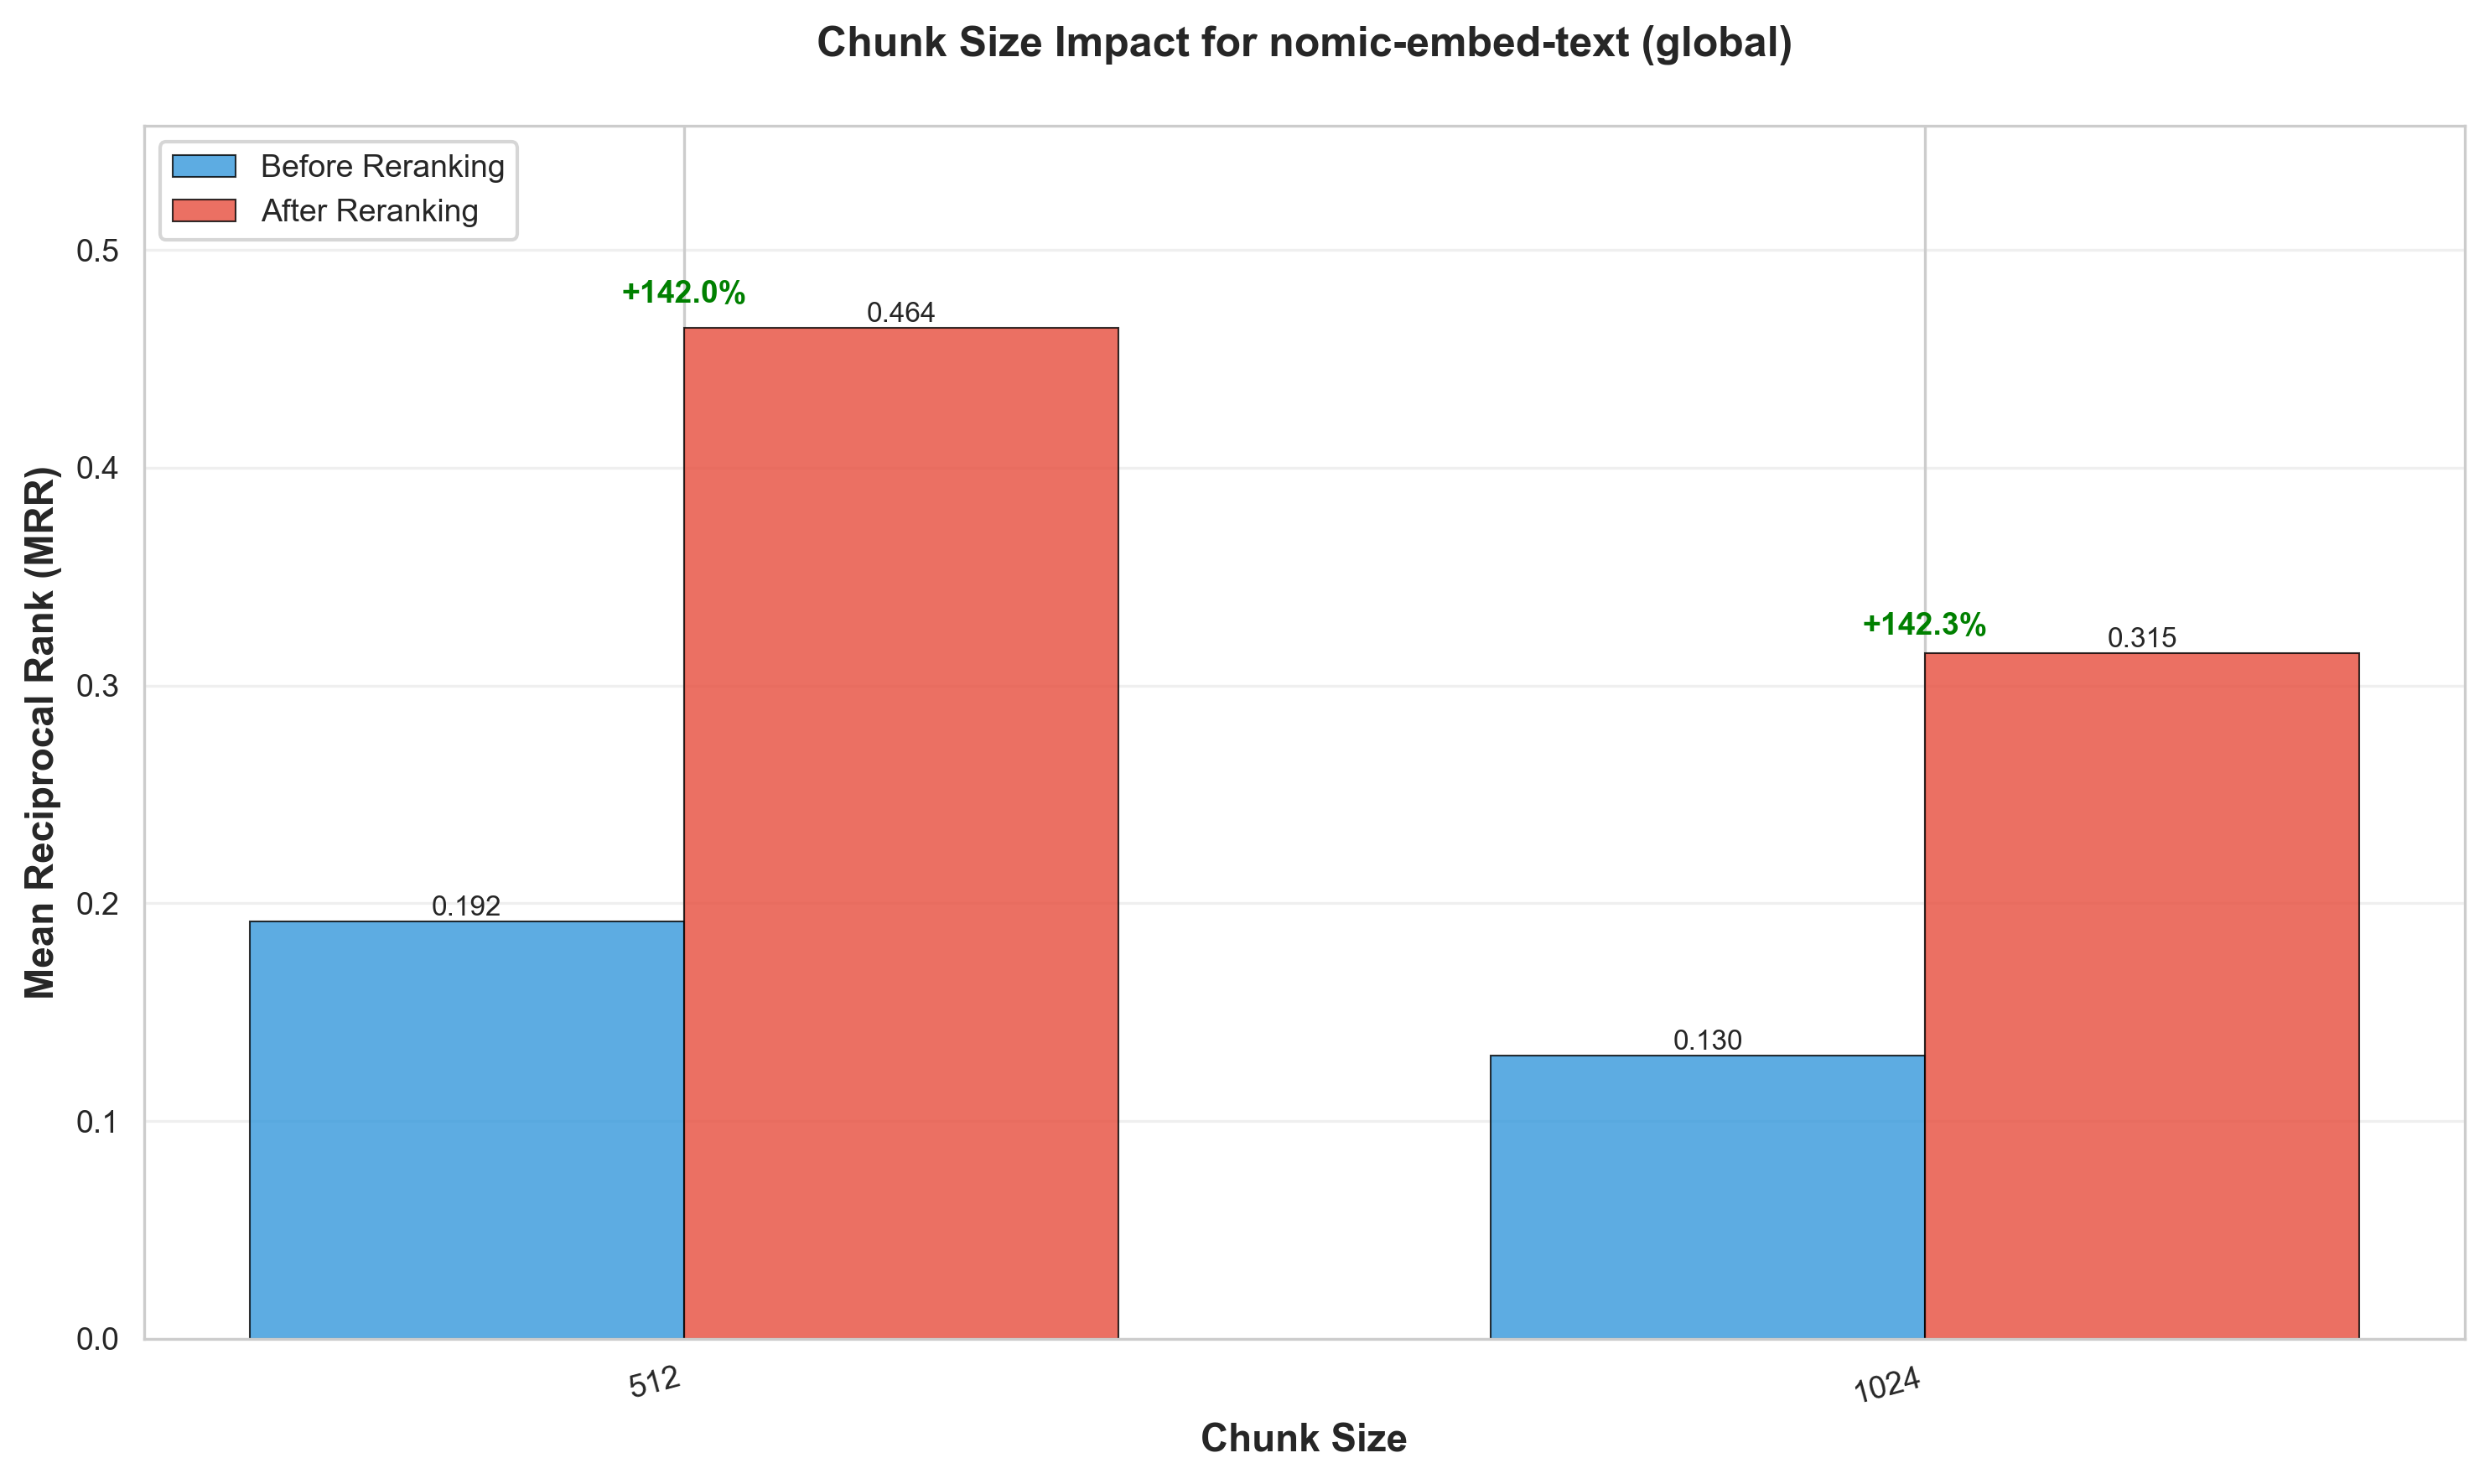

Processing: ../../evaluation_results/reranking/ollama_nomic-embed-text_chunk512_k80_global_rerank_k20-voyage-rerank-2.5.json
Processing: ../../evaluation_results/reranking/ollama_nomic-embed-text_chunk1024_k80_global_rerank_k20-voyage-rerank-2.5.json

✓ Exported 2 configuration summaries to: ../../evaluation_results/reranking/csv_exports/nomic-embed-text/global/chunk_size_comparison/chunk_size_comparison_summary.csv

✓ Workflow 2 completed!

WORKFLOW 2: Comparing Chunk Sizes
✓ Saved plot to: ../../evaluation_results/reranking/plots/nomic-embed-text/single/chunk_size_comparison/chunk_size_comparison_512_1024_mrr.png


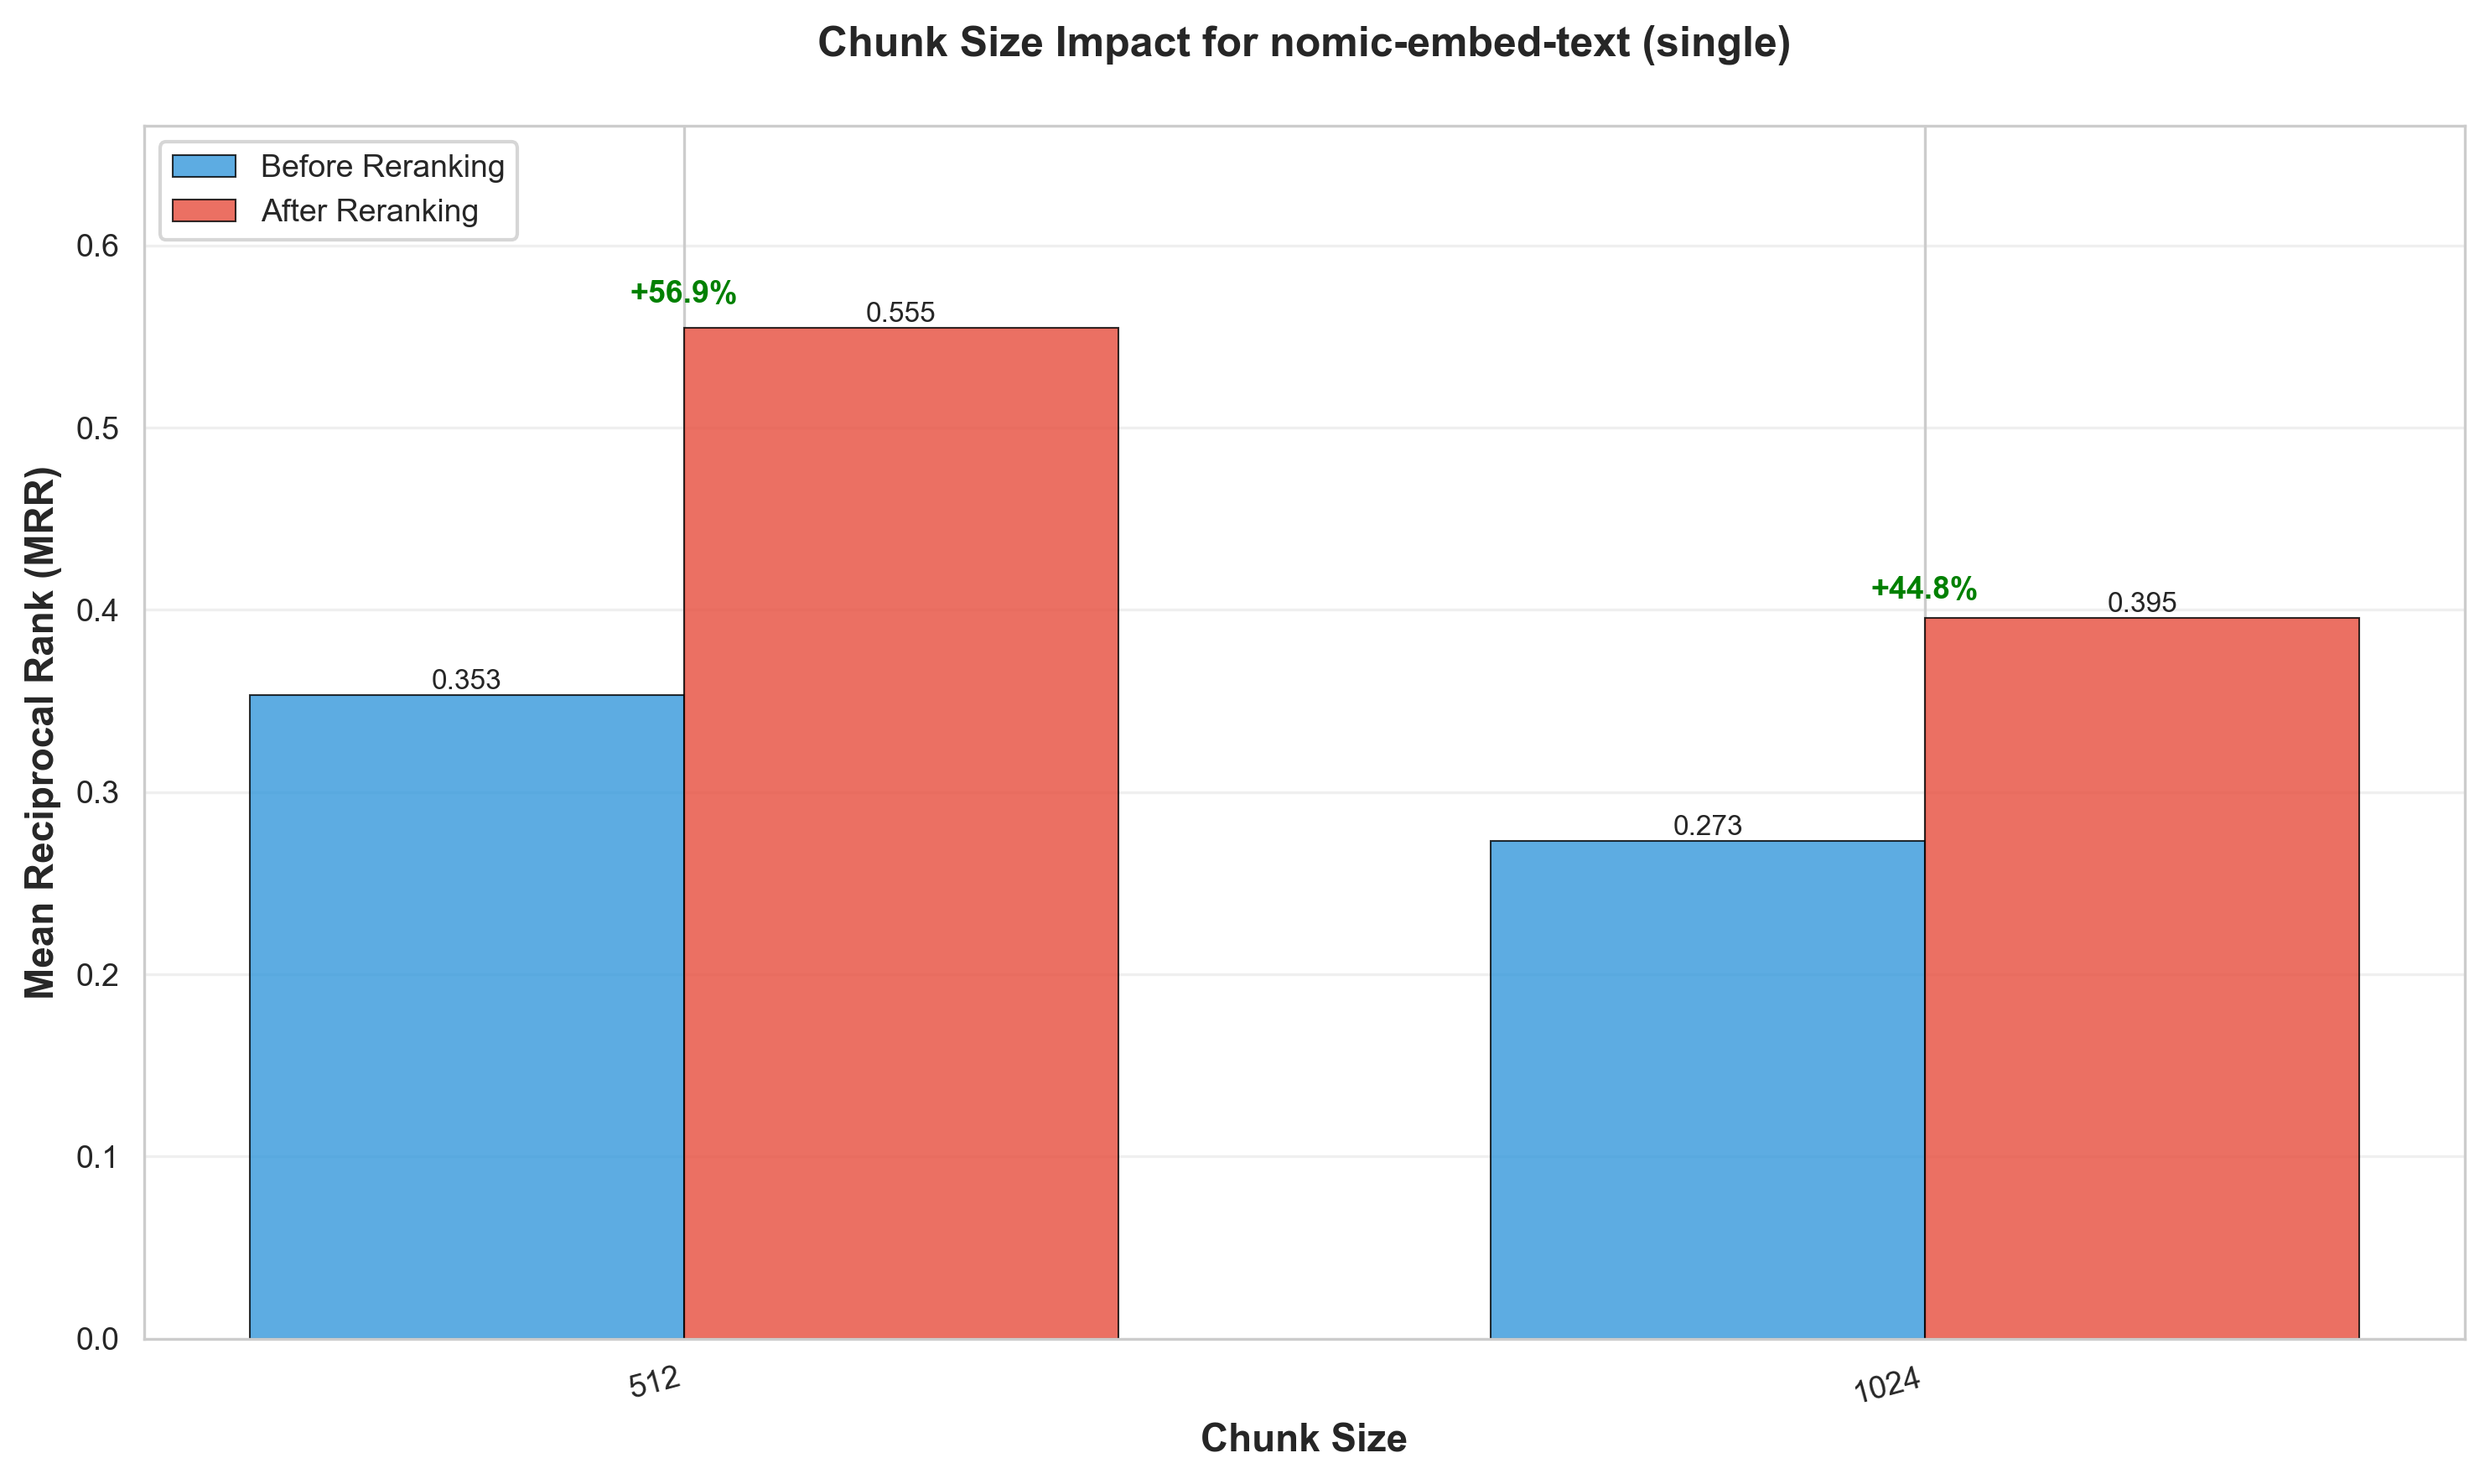

Processing: ../../evaluation_results/reranking/ollama_nomic-embed-text_chunk512_k80_single_rerank_k20-voyage-rerank-2.5.json
Processing: ../../evaluation_results/reranking/ollama_nomic-embed-text_chunk1024_k80_single_rerank_k20-voyage-rerank-2.5.json

✓ Exported 2 configuration summaries to: ../../evaluation_results/reranking/csv_exports/nomic-embed-text/single/chunk_size_comparison/chunk_size_comparison_summary.csv

✓ Workflow 2 completed!

WORKFLOW 2: Comparing Chunk Sizes
✓ Saved plot to: ../../evaluation_results/reranking/plots/voyage-3-large/global/chunk_size_comparison/chunk_size_comparison_512_1024_mrr.png


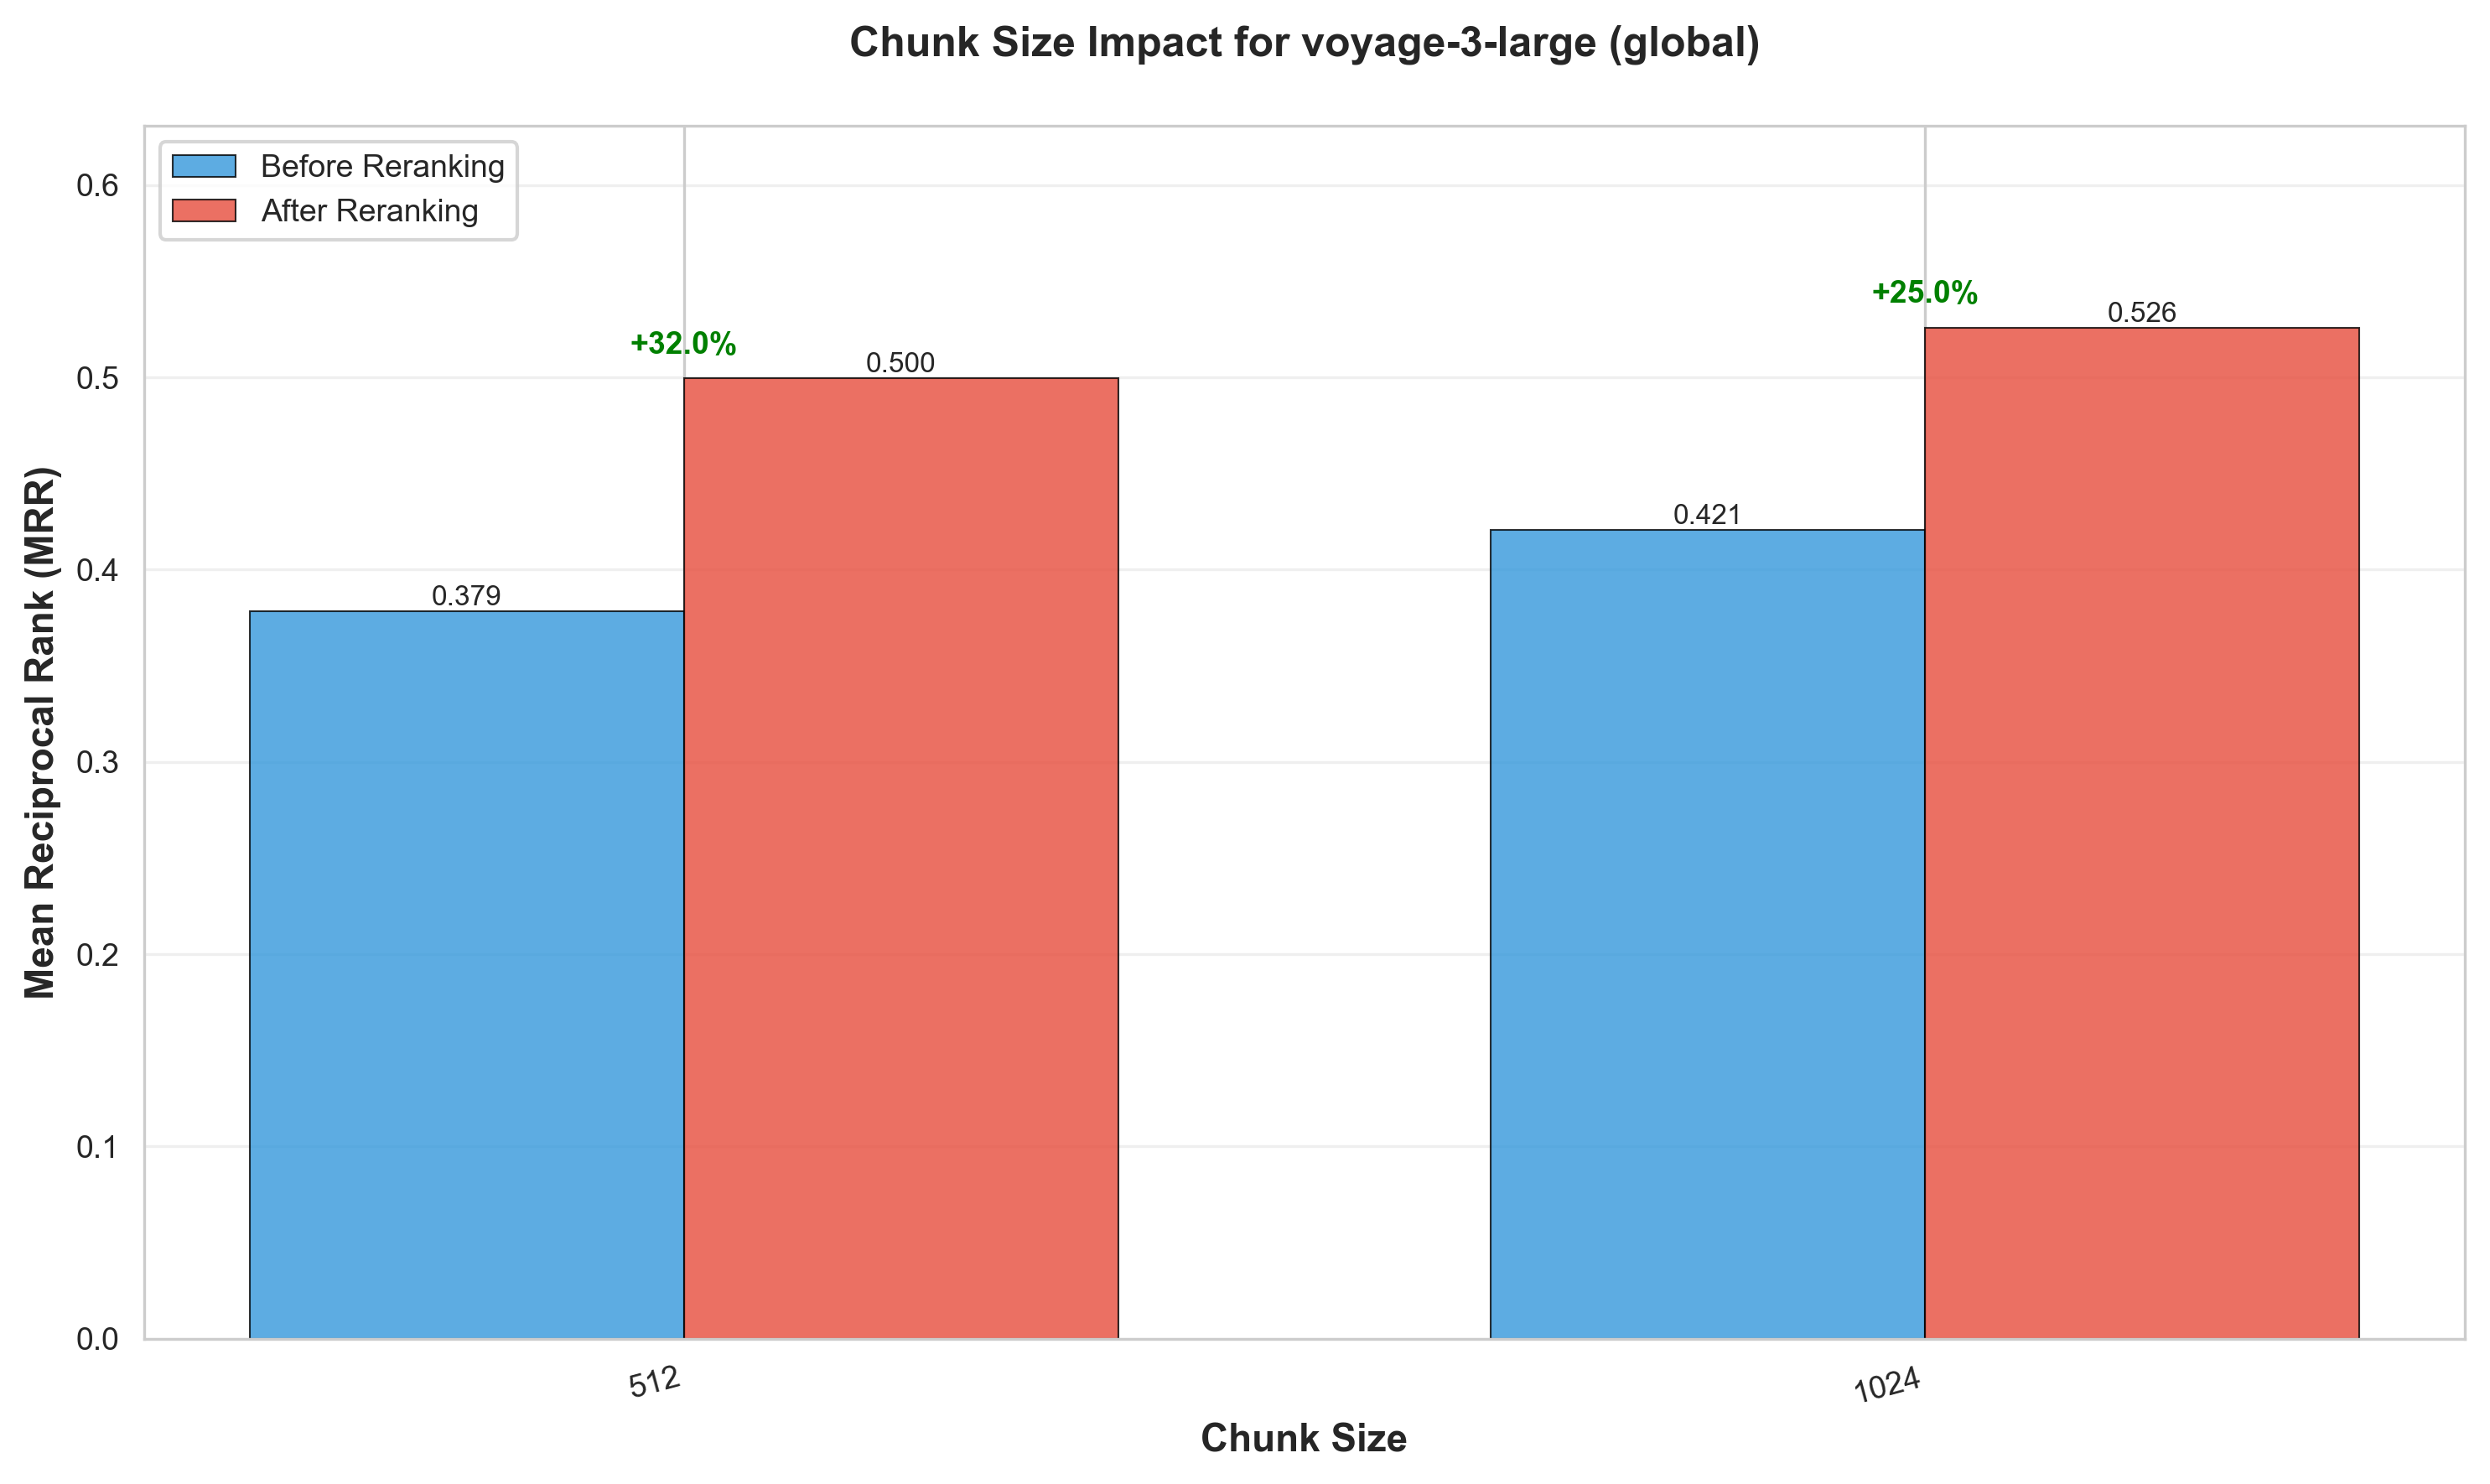

Processing: ../../evaluation_results/reranking/voyage_voyage-3-large_chunk512_k80_global_rerank_k20-voyage-rerank-2.5.json
Processing: ../../evaluation_results/reranking/voyage_voyage-3-large_chunk1024_k80_global_rerank_k20-voyage-rerank-2.5.json

✓ Exported 2 configuration summaries to: ../../evaluation_results/reranking/csv_exports/voyage-3-large/global/chunk_size_comparison/chunk_size_comparison_summary.csv

✓ Workflow 2 completed!

WORKFLOW 2: Comparing Chunk Sizes
✓ Saved plot to: ../../evaluation_results/reranking/plots/voyage-3-large/single/chunk_size_comparison/chunk_size_comparison_512_1024_mrr.png


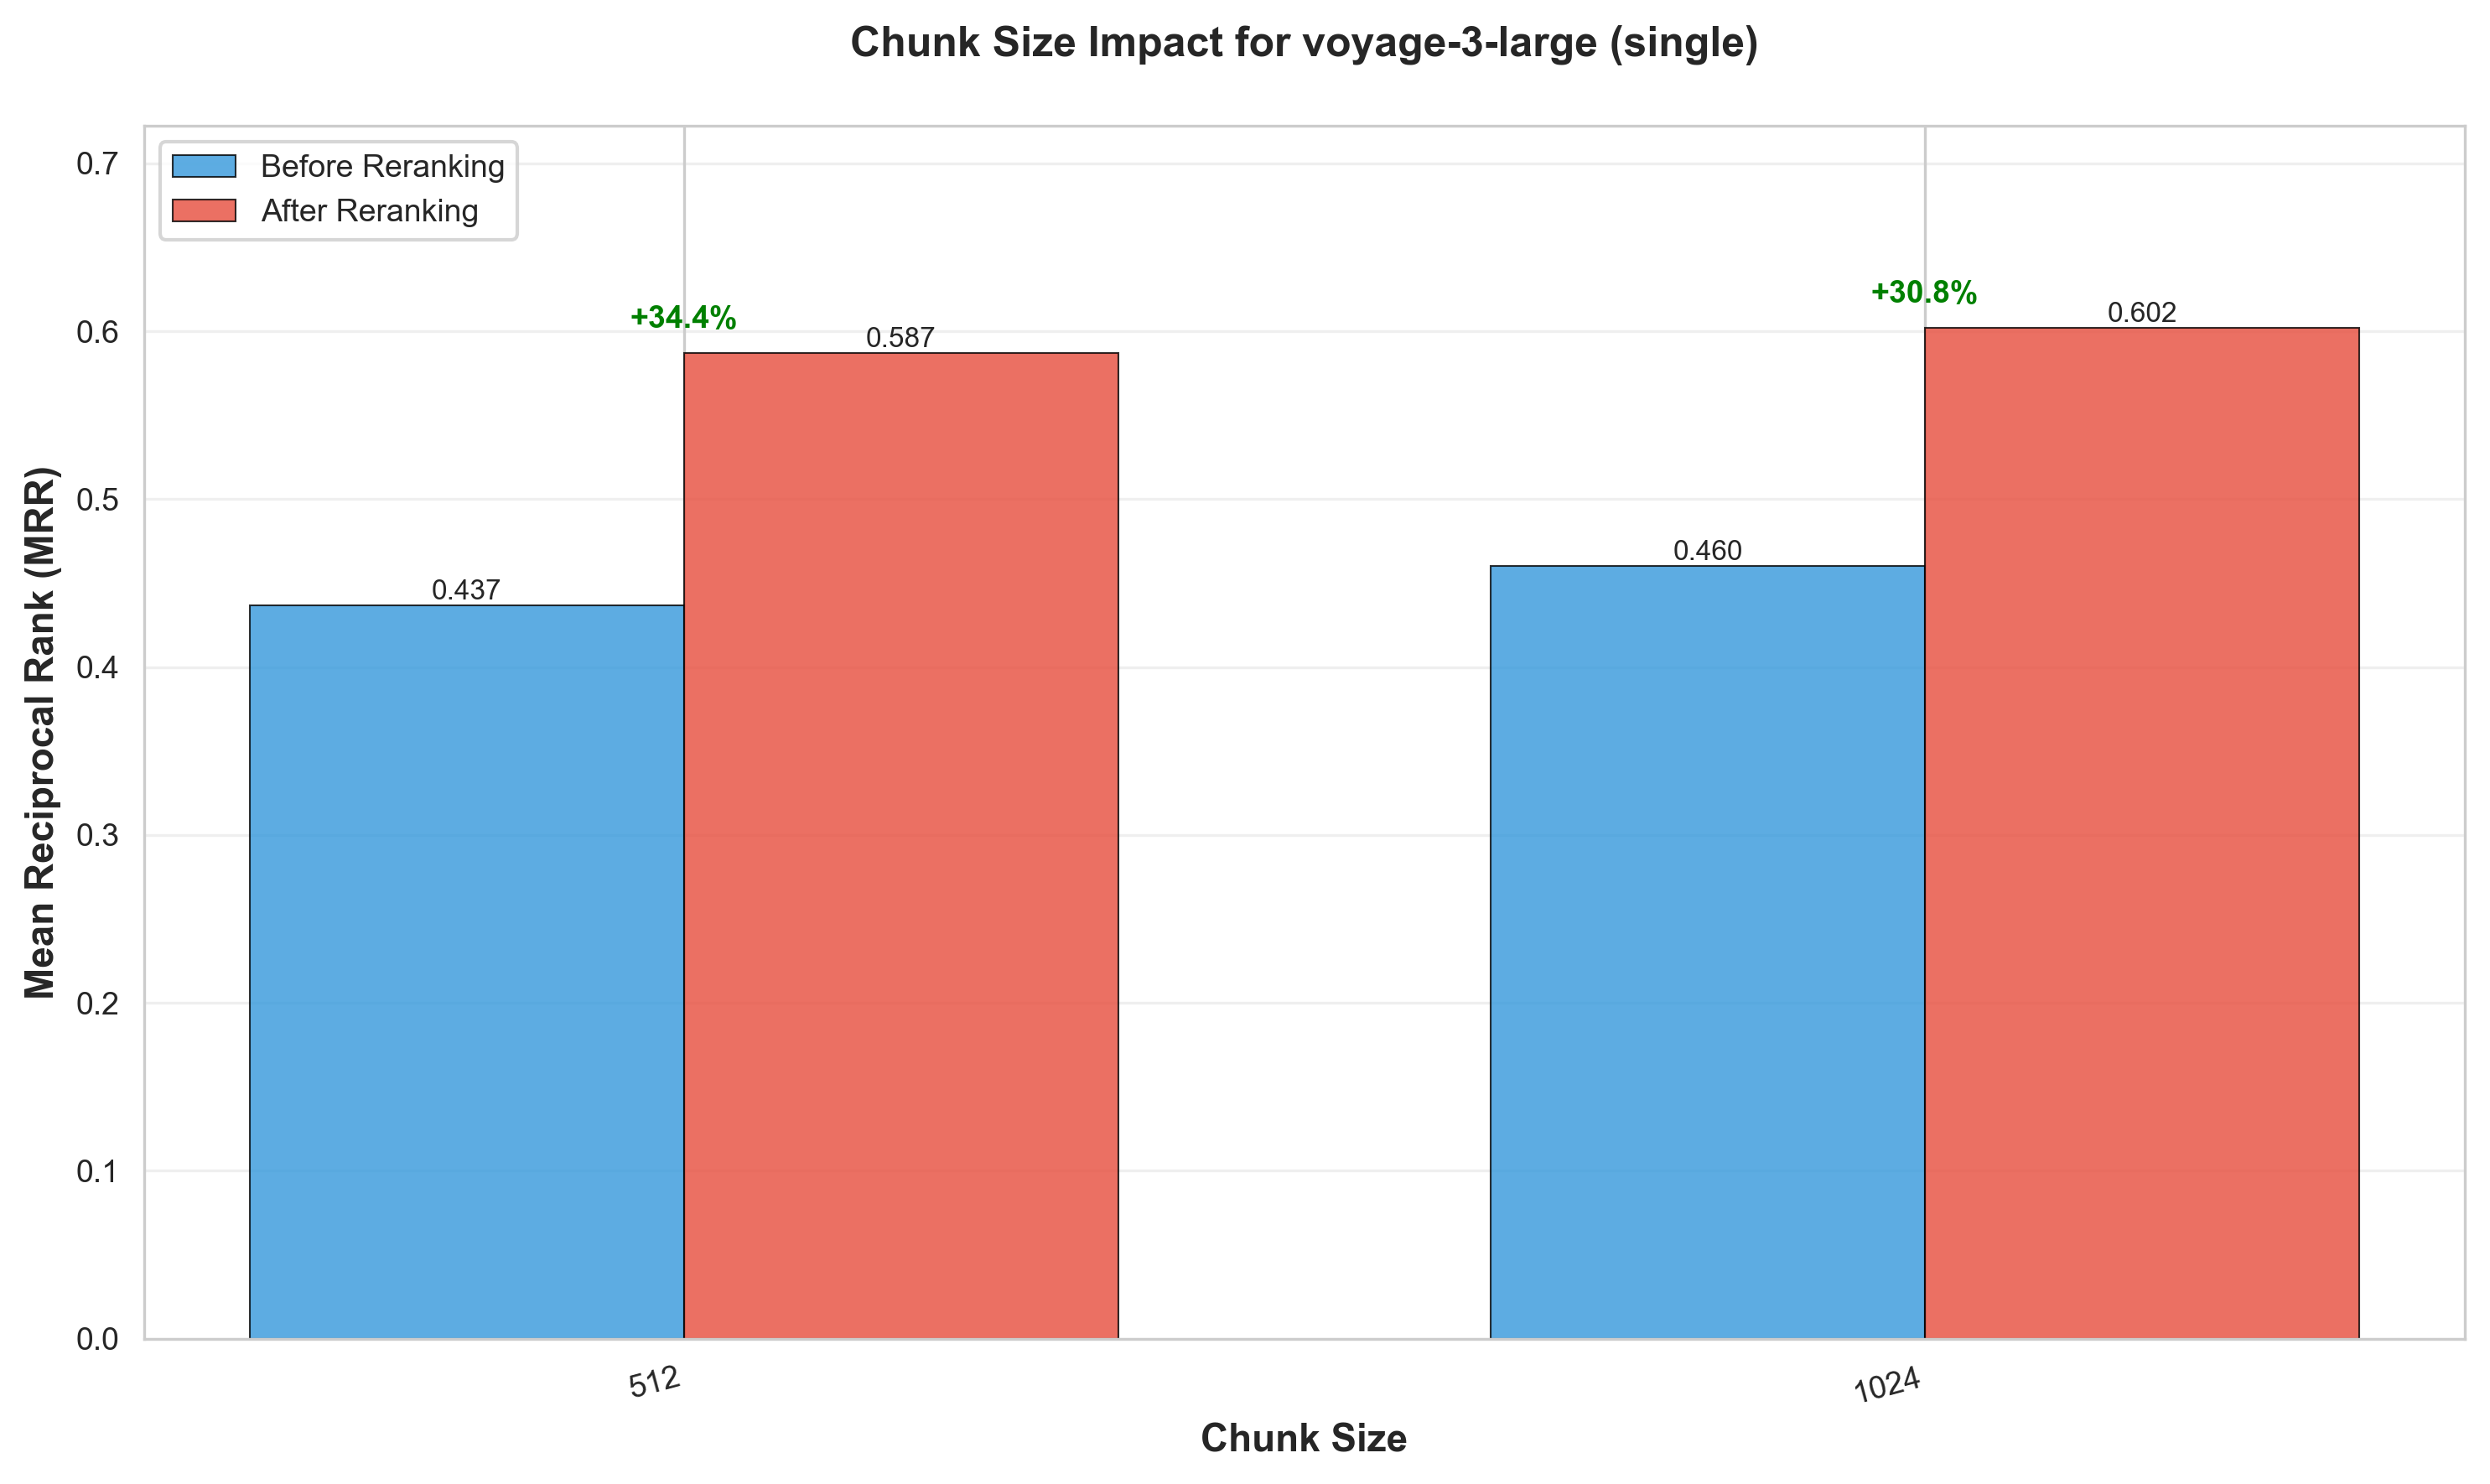

Processing: ../../evaluation_results/reranking/voyage_voyage-3-large_chunk512_k80_single_rerank_k20-voyage-rerank-2.5.json
Processing: ../../evaluation_results/reranking/voyage_voyage-3-large_chunk1024_k80_single_rerank_k20-voyage-rerank-2.5.json

✓ Exported 2 configuration summaries to: ../../evaluation_results/reranking/csv_exports/voyage-3-large/single/chunk_size_comparison/chunk_size_comparison_summary.csv

✓ Workflow 2 completed!

INSTRUCTIONS FOR USAGE:

1. Update the configuration at the top of this file:
   - RESULTS_DIR: Path to your JSON result files
   - PLOTS_DIR: Where to save plots
   - CSV_DIR: Where to save CSV exports

2. Uncomment the workflows you want to run

3. Modify the comparison_values and fixed_params in each workflow
   to match your actual configurations

4. Run the script:
   python comprehensive_example.py

5. Check the output directories for:
   - PNG plots in PLOTS_DIR
   - CSV files in CSV_DIR

NOTE: Make sure your JSON files follow the naming conventio

In [53]:
"""
Comprehensive Example: Reranking Analysis with Plots and CSV Exports

This script demonstrates a complete workflow for analyzing reranking results:
1. Compare different configurations with visualizations
2. Export results to CSV files
3. Generate publication-ready plots
"""

# ============================================================================
# CONFIGURATION
# ============================================================================

RESULTS_DIR = '../../evaluation_results/reranking'      # Directory with JSON result files
PLOTS_DIR = '../../evaluation_results/reranking/plots'           # Directory for output plots
CSV_DIR = '../../evaluation_results/reranking/csv_exports'       # Directory for CSV exports


# ============================================================================
# WORKFLOW 1: Compare Reranker Models
# ============================================================================

def workflow_1_compare_rerankers(
        provider: str = 'ollama',
        embedding_model: str = 'nomic-embed-text',
        mode: str = 'global'):
    """
    Complete workflow to compare different reranker models.
    Creates plots and exports CSV files.
    """
    print("\n" + "="*70)
    print("WORKFLOW 1: Comparing Reranker Models")
    print("="*70)
    
    comparison_params = {
        'comparison_dimension': 'reranker_model',
        'comparison_values': [
            'cross-encoder-ms-marco-miniLM',
            'bge-reranker-large',
            'voyage-rerank-2.5'
        ],
        'fixed_params': {
            'provider': provider,
            'embedding_model': embedding_model,
            'chunk_size': 512,
            'k_retrieve': 80,
            'k_rerank': 20,
            'mode': mode
        }
    }
    
    # 1. Create plots for all metrics
    print("\n1. Creating comparison plots...")
    for metric in ['text_mrr', 'text_recall', 'text_precision', 'text_f1']:
        plot_metric_comparison(
            comparison_dimension=comparison_params['comparison_dimension'],
            comparison_values=comparison_params['comparison_values'],
            fixed_params=comparison_params['fixed_params'],
            metric=metric,
            show_improvement=True,
            results_dir=RESULTS_DIR,
            output_file=f'{PLOTS_DIR}/{embedding_model}/{mode}/reranker_comparison_{metric}.png',
            title=f'Reranking Impact for {embedding_model} ({mode})'
        )
    
    # 2. Print text summary
    print("\n2. Printing text summary...")
    print_comparison_summary(
        comparison_dimension=comparison_params['comparison_dimension'],
        comparison_values=comparison_params['comparison_values'],
        fixed_params=comparison_params['fixed_params'],
        results_dir=RESULTS_DIR
    )
    
    # 3. Export CSV files
    print("\n3. Exporting CSV files...")
    export_results_from_config(
        comparison_dimension=comparison_params['comparison_dimension'],
        comparison_values=comparison_params['comparison_values'],
        fixed_params=comparison_params['fixed_params'],
        results_dir=RESULTS_DIR,
        output_dir=f'{CSV_DIR}/{embedding_model}/{mode}/reranker_comparison',
        export_detailed=True,
        export_summary=True,
        export_matrix=True
    )
    
    print("\n✓ Workflow 1 completed!")


# ============================================================================
# WORKFLOW 2: Compare Chunk Sizes
# ============================================================================

def workflow_2_compare_chunk_sizes(
        provider: str = 'ollama',
        embedding_model: str = 'nomic-embed-text',
        mode: str = 'global',
        chunk_sizes: List[int] = [512, 1024],
        reranker_model: str = 'voyage-rerank-2.5'
    ):
    """
    Complete workflow to compare different chunk sizes.
    """
    print("\n" + "="*70)
    print("WORKFLOW 2: Comparing Chunk Sizes")
    print("="*70)
    
    comparison_params = {
        'comparison_dimension': 'chunk_size',
        'comparison_values': chunk_sizes,
        'fixed_params': {
            'provider': provider,
            'embedding_model': embedding_model,
            'k_retrieve': 80,
            'k_rerank': 20,
            'mode': mode,
            'reranker_model': reranker_model
        }
    }

    # create a variable and convert chunk_sizes to string for file naming
    chunk_sizes_str = '_'.join(map(str, chunk_sizes))
    
    # Create MRR plot
    plot_metric_comparison(
        comparison_dimension=comparison_params['comparison_dimension'],
        comparison_values=comparison_params['comparison_values'],
        fixed_params=comparison_params['fixed_params'],
        metric='text_mrr',
        show_improvement=True,
        results_dir=RESULTS_DIR,
        output_file=f'{PLOTS_DIR}/{embedding_model}/{mode}/chunk_size_comparison/chunk_size_comparison_{chunk_sizes_str}_mrr.png',
        title=f'Chunk Size Impact for {embedding_model} ({mode})'
    )
    
    # Export CSV
    export_results_from_config(
        comparison_dimension=comparison_params['comparison_dimension'],
        comparison_values=comparison_params['comparison_values'],
        fixed_params=comparison_params['fixed_params'],
        results_dir=RESULTS_DIR,
        output_dir=f'{CSV_DIR}/{embedding_model}/{mode}/chunk_size_comparison',
        export_detailed=False,  # Skip detailed export for brevity
        export_summary=True,
        export_matrix=False
    )
    
    print("\n✓ Workflow 2 completed!")


# ============================================================================
# WORKFLOW 3: Compare Retrieval Modes
# ============================================================================

def workflow_3_compare_modes():
    """
    Complete workflow to compare global vs single document mode.
    """
    print("\n" + "="*70)
    print("WORKFLOW 3: Comparing Retrieval Modes")
    print("="*70)
    
    comparison_params = {
        'comparison_dimension': 'mode',
        'comparison_values': ['global', 'single'],
        'fixed_params': {
            'provider': 'ollama',
            'embedding_model': 'nomic-embed-text',
            'chunk_size': 512,
            'k_retrieve': 80,
            'k_rerank': 20,
            'reranker_model': 'cross-encoder-ms-marco-miniLM'
        }
    }
    
    # Create plots for MRR and Recall
    for metric in ['text_mrr', 'text_recall']:
        plot_metric_comparison(
            comparison_dimension=comparison_params['comparison_dimension'],
            comparison_values=comparison_params['comparison_values'],
            fixed_params=comparison_params['fixed_params'],
            metric=metric,
            show_improvement=True,
            results_dir=RESULTS_DIR,
            output_file=f'{PLOTS_DIR}/mode_comparison_{metric}.png'
        )
    
    # Print summary
    print_comparison_summary(
        comparison_dimension=comparison_params['comparison_dimension'],
        comparison_values=comparison_params['comparison_values'],
        fixed_params=comparison_params['fixed_params'],
        results_dir=RESULTS_DIR
    )
    
    print("\n✓ Workflow 3 completed!")


# ============================================================================
# WORKFLOW 4: Comprehensive Analysis of All Configurations
# ============================================================================

def workflow_4_comprehensive_analysis():
    """
    Export comprehensive CSV files with all configurations.
    """
    print("\n" + "="*70)
    print("WORKFLOW 4: Comprehensive Analysis")
    print("="*70)
    
    # Find all JSON files
    print("\nSearching for all result files...")
    try:
        all_files = find_json_files(
            results_dir=RESULTS_DIR,
            provider='ollama',  # Change as needed
            embedding_model=None,  # Match all
            chunk_size=None,
            k_retrieve=80,
            mode=None,
            k_rerank=20,
            reranker_model=None
        )
        print(f"Found {len(all_files)} result files")
        
        # Export detailed results
        print("\n1. Exporting detailed query-level results...")
        export_detailed_results_csv(
            json_files=all_files,
            output_file=f'{CSV_DIR}/all_detailed_results.csv'
        )
        
        # Export summary statistics
        print("\n2. Exporting summary statistics...")
        export_summary_statistics_csv(
            json_files=all_files,
            output_file=f'{CSV_DIR}/all_summary_statistics.csv'
        )
        
        # Export comprehensive metrics comparison
        print("\n3. Exporting all metrics comparison...")
        export_all_metrics_comparison_csv(
            json_files=all_files,
            output_file=f'{CSV_DIR}/all_metrics_comparison.csv'
        )
        
        # Export comparison matrices for each metric
        print("\n4. Exporting comparison matrices...")
        for metric in ['text_mrr', 'text_recall', 'text_precision', 'text_f1']:
            export_comparison_matrix_csv(
                json_files=all_files,
                metric=metric,
                pivot_rows='chunk_size',
                pivot_cols='reranker_model',
                value_type='improvement_pct',
                output_file=f'{CSV_DIR}/matrix_{metric}_improvement_pct.csv'
            )
        
        print("\n✓ Workflow 4 completed!")
        
    except FileNotFoundError as e:
        print(f"Error: {e}")


# ============================================================================
# WORKFLOW 5: Custom Analysis
# ============================================================================

def workflow_5_custom_analysis():
    """
    Template for custom analysis.
    Modify this function for your specific needs.
    """
    print("\n" + "="*70)
    print("WORKFLOW 5: Custom Analysis")
    print("="*70)
    
    # Example: Compare specific configurations
    # Modify the parameters below to match your needs
    
    # Option 1: Compare reranker models for Voyage embeddings
    plot_metric_comparison(
        comparison_dimension='reranker_model',
        comparison_values=['voyage-rerank-2.5'],  # Add more if you have them
        fixed_params={
            'provider': 'voyage',
            'embedding_model': 'voyage-3-large',
            'chunk_size': 512,
            'k_retrieve': 80,
            'k_rerank': 20,
            'mode': 'global'
        },
        metric='text_mrr',
        results_dir=RESULTS_DIR,
        output_file=f'{PLOTS_DIR}/custom_voyage_comparison.png'
    )
    
    # Option 2: Export specific configuration
    # ... add your custom analysis here ...
    
    print("\n✓ Workflow 5 completed!")


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*70)
    print("COMPREHENSIVE RERANKING ANALYSIS")
    print("="*70)
    print(f"\nResults directory: {RESULTS_DIR}")
    print(f"Plots directory: {PLOTS_DIR}")
    print(f"CSV exports directory: {CSV_DIR}")
    print("\nAvailable workflows:")
    print("  1. Compare reranker models")
    print("  2. Compare chunk sizes")
    print("  3. Compare retrieval modes")
    print("  4. Comprehensive analysis (all configurations)")
    print("  5. Custom analysis (template)")
    print("\nUncomment the workflows you want to run:")
    print("="*70)
    
    # Uncomment the workflows you want to run:

    # workflow_1_compare_rerankers(provider='ollama', embedding_model='nomic-embed-text', mode='global')
    # workflow_1_compare_rerankers(provider='ollama', embedding_model='nomic-embed-text', mode='single')

    # workflow_1_compare_rerankers(provider='voyage', embedding_model='voyage-3-large', mode='global')
    # workflow_1_compare_rerankers(provider='voyage', embedding_model='voyage-3-large', mode='single')


    workflow_2_compare_chunk_sizes(provider='ollama', embedding_model='nomic-embed-text', mode='global', chunk_sizes=[512, 1024], reranker_model='voyage-rerank-2.5')
    workflow_2_compare_chunk_sizes(provider='ollama', embedding_model='nomic-embed-text', mode='single', chunk_sizes=[512, 1024], reranker_model='voyage-rerank-2.5')

    workflow_2_compare_chunk_sizes(provider='voyage', embedding_model='voyage-3-large', mode='global', chunk_sizes=[512, 1024], reranker_model='voyage-rerank-2.5')
    workflow_2_compare_chunk_sizes(provider='voyage', embedding_model='voyage-3-large', mode='single', chunk_sizes=[512, 1024], reranker_model='voyage-rerank-2.5')

    # workflow_3_compare_modes()
    # workflow_4_comprehensive_analysis()
    # workflow_5_custom_analysis()
    
    print("\n" + "="*70)
    print("INSTRUCTIONS FOR USAGE:")
    print("="*70)
    print("""
1. Update the configuration at the top of this file:
   - RESULTS_DIR: Path to your JSON result files
   - PLOTS_DIR: Where to save plots
   - CSV_DIR: Where to save CSV exports

2. Uncomment the workflows you want to run

3. Modify the comparison_values and fixed_params in each workflow
   to match your actual configurations

4. Run the script:
   python comprehensive_example.py

5. Check the output directories for:
   - PNG plots in PLOTS_DIR
   - CSV files in CSV_DIR

NOTE: Make sure your JSON files follow the naming convention:
{provider}_{model}_chunk{size}_k{retrieve}_{mode}_rerank_k{rerank}-{reranker}.json

Example:
ollama_nomic-embed-text_chunk512_k80_global_rerank_k20-cross-encoder-ms-marco-miniLM.json
    """)
    print("="*70 + "\n")

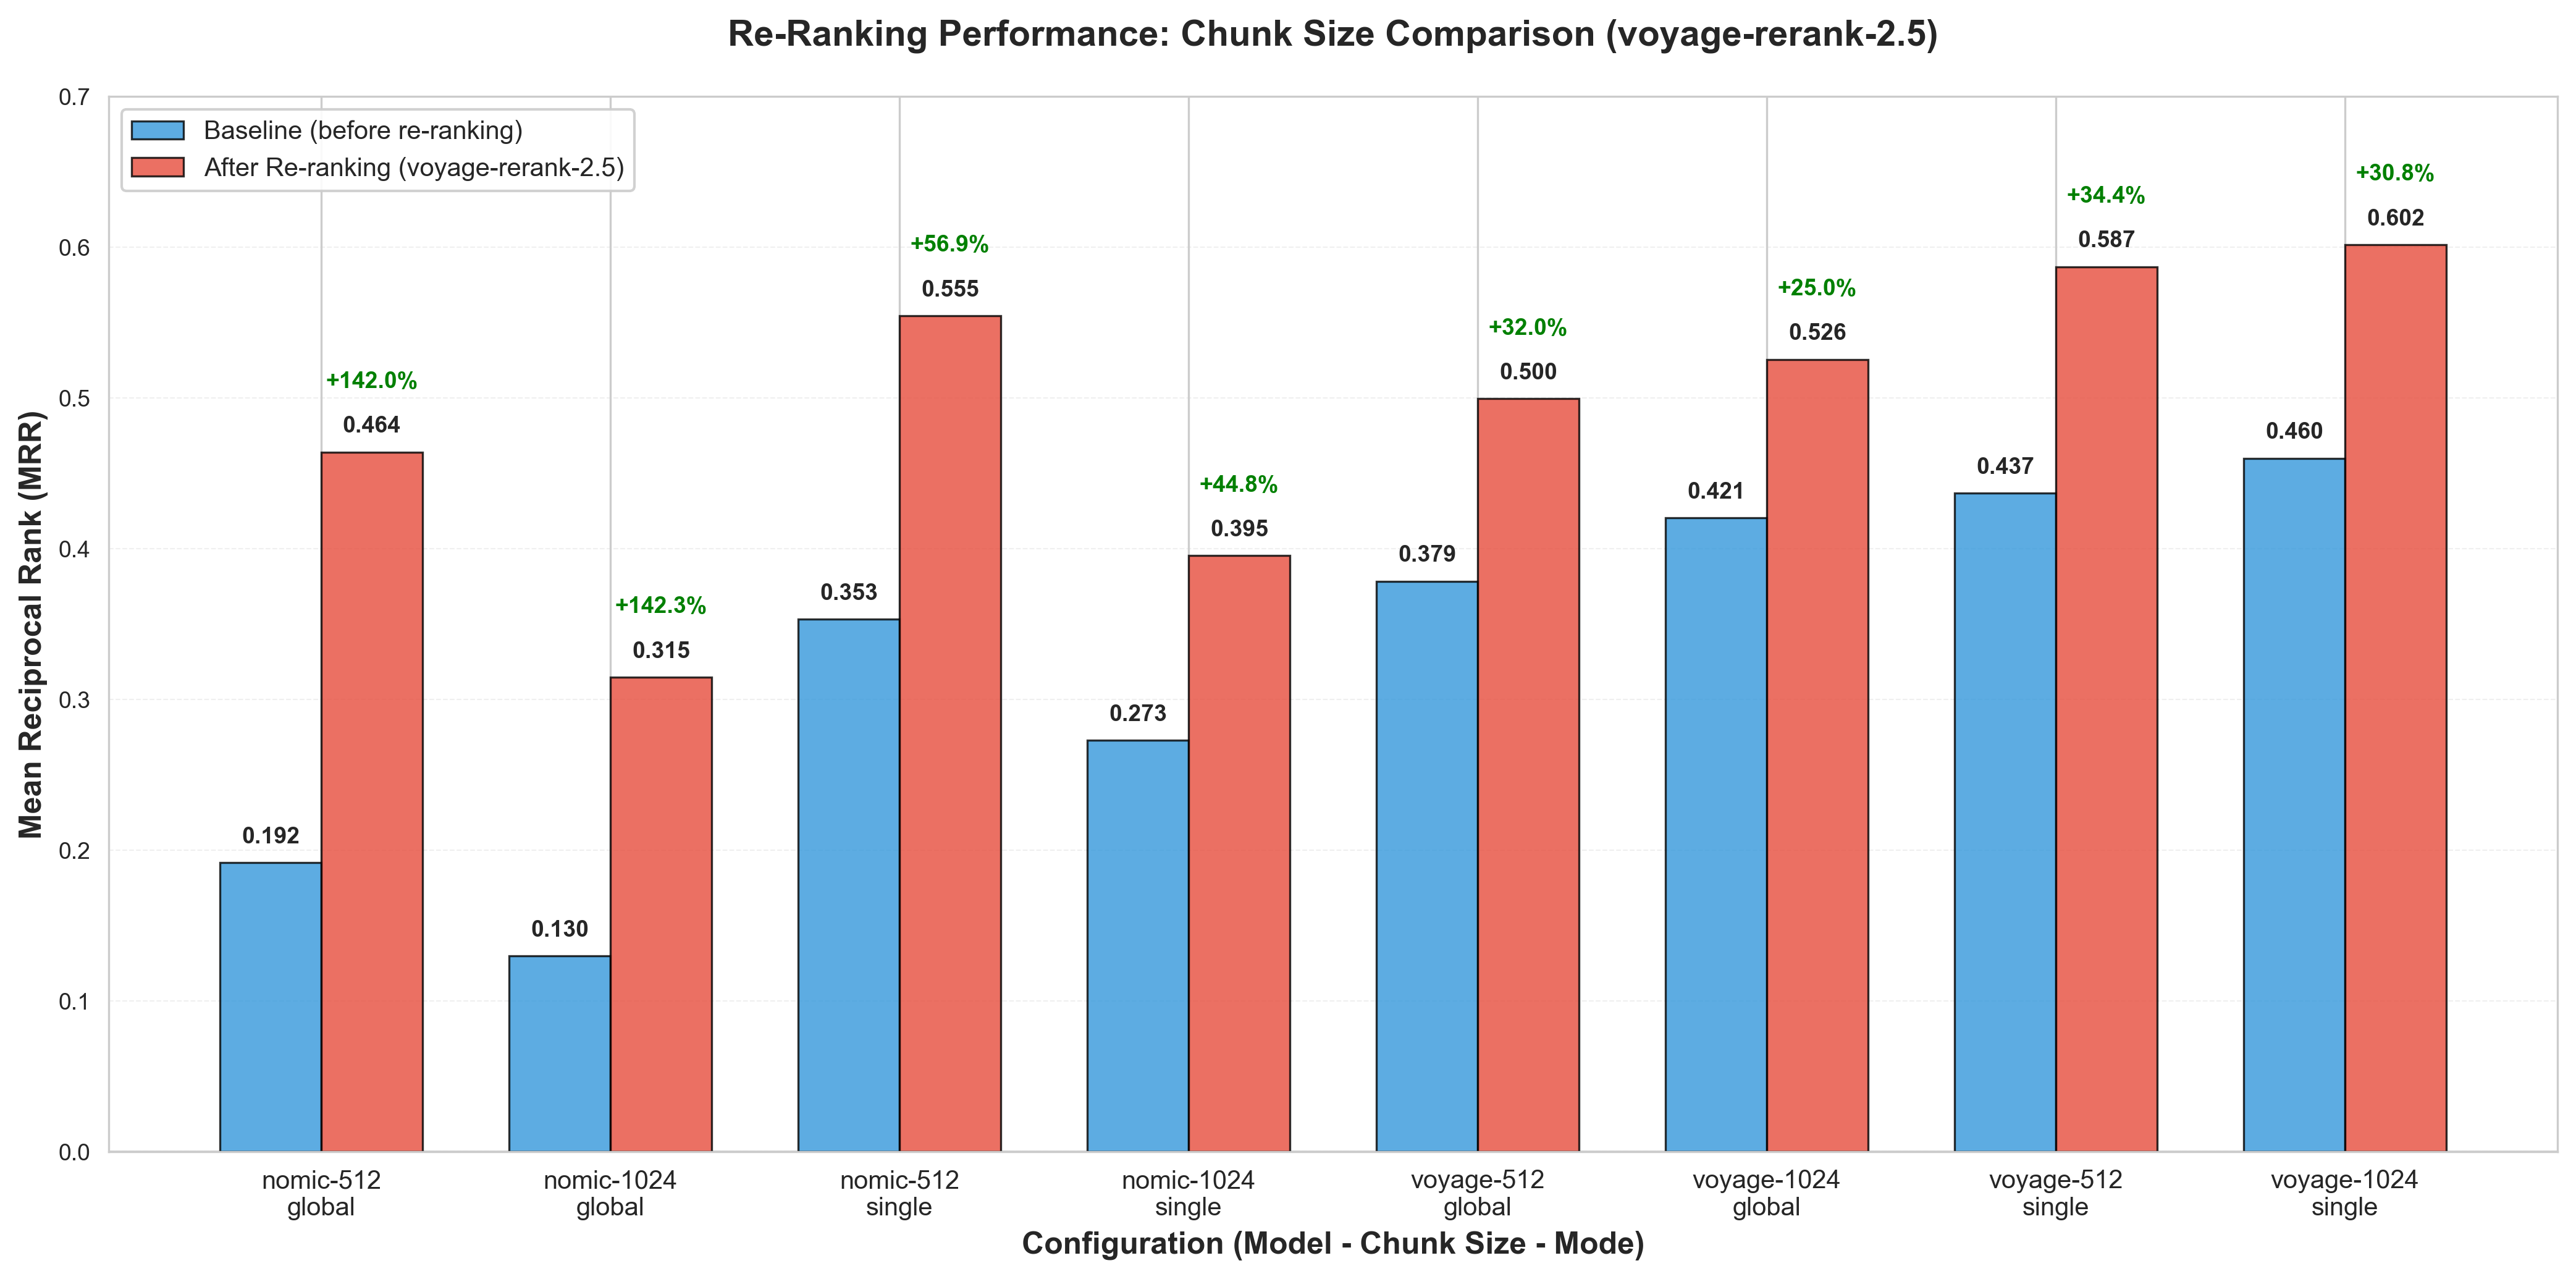

VISUALIZATION COMPLETE

Files saved:
  - reranking_chunk_comparison.png (high resolution)
  - reranking_chunk_comparison.pdf (vector format)

Key observations:
  - Green percentages show improvement from re-ranking
  - nomic-embed-text: chunk 512 consistently outperforms 1024
  - voyage-3-large: chunk 1024 achieves highest absolute MRR


In [59]:
"""
Re-Ranking Chunk Size Comparison Visualization
=============================================
Compares baseline vs re-ranked MRR across 8 configurations:
- 2 models (nomic-embed-text, voyage-3-large)
- 2 chunk sizes (512, 1024)
- 2 modes (global, singledoc)

Each configuration shows a pair of bars (baseline, re-ranked) with improvement percentage.
"""

import matplotlib.pyplot as plt
import numpy as np

# ============================================================================
# HARDCODED DATA FROM EXPERIMENTS
# ============================================================================

# Configuration labels (short names for x-axis)
config_labels = [
    'nomic-512\nglobal',
    'nomic-1024\nglobal',
    'nomic-512\nsingle',
    'nomic-1024\nsingle',
    'voyage-512\nglobal',
    'voyage-1024\nglobal',
    'voyage-512\nsingle',
    'voyage-1024\nsingle'
]

# Baseline MRR (avg_mrr_k_rerank - top-20 without re-ranking)
baseline_mrr = [
    0.1918,  # nomic-512-global
    0.1299,  # nomic-1024-global
    0.3534,  # nomic-512-single
    0.2730,  # nomic-1024-single
    0.3785,  # voyage-512-global
    0.4206,  # voyage-1024-global
    0.4369,  # voyage-512-single
    0.4601   # voyage-1024-single
]

# Re-ranked MRR (avg_mrr_reranked - after voyage-rerank-2.5)
reranked_mrr = [
    0.4641,  # nomic-512-global
    0.3148,  # nomic-1024-global
    0.5546,  # nomic-512-single
    0.3954,  # nomic-1024-single
    0.4996,  # voyage-512-global
    0.5256,  # voyage-1024-global
    0.5871,  # voyage-512-single
    0.6018   # voyage-1024-single
]

# Improvement percentages
improvement_pct = [
    141.97,  # nomic-512-global
    142.34,  # nomic-1024-global
    56.93,   # nomic-512-single
    44.84,   # nomic-1024-single
    31.99,   # voyage-512-global
    24.96,   # voyage-1024-global
    34.38,   # voyage-512-single
    30.80    # voyage-1024-single
]

# ============================================================================
# VISUALIZATION
# ============================================================================

# Set up the figure
fig, ax = plt.subplots(figsize=(14, 7))

# X-axis positions
x_positions = np.arange(len(config_labels))
bar_width = 0.35

# Create bars
bars1 = ax.bar(x_positions - bar_width/2, baseline_mrr, bar_width, 
               label='Baseline (before re-ranking)', 
               color='#3498db', alpha=0.8, edgecolor='black', linewidth=0.8)

bars2 = ax.bar(x_positions + bar_width/2, reranked_mrr, bar_width, 
               label='After Re-ranking (voyage-rerank-2.5)', 
               color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=0.8)

# Add values to the top of both bars
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.01,
            f'{height1:.3f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.01,
            f'{height2:.3f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add improvement percentage labels in GREEN above re-ranked bars
for i, (bar, pct) in enumerate(zip(bars2, improvement_pct)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.04,
            f'+{pct:.1f}%',
            ha='center', va='bottom', 
            fontsize=9, fontweight='bold', color='green')

# Customize the plot
ax.set_xlabel('Configuration (Model - Chunk Size - Mode)', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Reciprocal Rank (MRR)', fontsize=12, fontweight='bold')
ax.set_title('Re-Ranking Performance: Chunk Size Comparison (voyage-rerank-2.5)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_positions)
ax.set_xticklabels(config_labels, fontsize=10)
ax.legend(loc='upper left', fontsize=10, framealpha=0.9)

# Add grid for better readability
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Set y-axis limits
ax.set_ylim(0, 0.70)

# Add horizontal line at y=0 for clarity
ax.axhline(y=0, color='black', linewidth=0.8)

# Tight layout
plt.tight_layout()

# # Save the figure
plt.savefig(f'../../evaluation_results/reranking/plots/reranking_chunk_comparison_thesis.png', dpi=300, bbox_inches='tight')
# plt.savefig('reranking_chunk_comparison.pdf', bbox_inches='tight')

# Display the plot
plt.show()

print("=" * 70)
print("VISUALIZATION COMPLETE")
print("=" * 70)
print("\nFiles saved:")
print("  - reranking_chunk_comparison.png (high resolution)")
print("  - reranking_chunk_comparison.pdf (vector format)")
print("\nKey observations:")
print("  - Green percentages show improvement from re-ranking")
print("  - nomic-embed-text: chunk 512 consistently outperforms 1024")
print("  - voyage-3-large: chunk 1024 achieves highest absolute MRR")
print("=" * 70)